# CAST AI Task Solution

In this notebook we will be exploring a dataset provided to us for the purposes of EDA and modelling

## Introduction

In this task we are presented with an anonymised dataset containing over 300 columns of data, with hundreds of thousands of data points. We are tasked with creating a classification model towards the label/target presented in the data. Given that the data is anonymised, and that we have restricted access to domain expertise for the data/business processes which created this dataset, we will be taking a more mechanical approach to this assignment, acknowledging that more in-depth data cleaning, and specialised feature engineering can be achieved on real data, with access to domain experts who can assist in decoding and interpreting data, its values, its irregularities, and so on.

### Short Data Discussion

Some notes and inferences that can be made about the dataset:

- The dataset is mainly numerical data of various kinds, various skews, and more generally speaking, various distributions. This will be important during the EDA and feature engineering steps. The data contains only a handful of categorical columns, and one datetime column.
- The dataset has a categorical column with region names commonly found in AWS as part of their region options, following the same naming conventions, e.g. eu-central-1, us-east-1, and so on. 
- The target column, labelled "label", has two values inside, namely "Interrupted" and "Continue".
- While most column names have a "_numeric" suffix to them, indicating that the column is a pure numeric column, some others have the suffix "_string", while containing float/int type values, indicating that they were either encoded or transformed at some point in some way to arrive at the numeric values.

What can we infer about this dataset then? Well, in short, this could be a dataset relating to the interruption of various spot instances on a kubernetes cluster, where we are presented with various environment variables, workload metadata, and other relevant measurements and metadata about the workload, environment, region, and so on, so that we can attempt to predict whether a spot instance will be interrupted shortly or within some fixed interval of time T shortly after the prediction. 

Assuming this 'guess' about the data origins is correct, what we have is potentially a problem with high business impact/value, which can help product teams better predict and plan-ahead for various service interruptions by either reserving more instances, or back-up or execute their workloads more efficiently with this information in mind.

### Assumptions

Some assumptions I have made while working with this dataset are:

- The rows are row-wise independent of one another - for example, I notice that there is a datetime field representing (likely) the datetime when this data was generated or collected. I assume that there is no connection between one data point and another, given that there is no ID to imply that two or more data points are connected in some way to each other. I also assume that there is no implicit time dimension to this data, in that the events do not correlate with other events in a time neighbourhood of other events, e.g. within the same minute, second, hour, etc.

In [1]:
import numpy as np
import pandas as pd

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import importlib

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [6]:
import datautils.DataSampler
import datautils.ClassRebalancer
import utils.EDA
import features.FeatureEngineer

In [7]:
importlib.reload(datautils.DataSampler)
importlib.reload(datautils.ClassRebalancer)
importlib.reload(utils.EDA)
importlib.reload(features.FeatureEngineer)

<module 'features.FeatureEngineer' from 'c:\\Users\\vctrg\\OneDrive\\Documents\\Github\\CastAITask\\src\\features\\FeatureEngineer.py'>

In [8]:
data_sampler = datautils.DataSampler.DataSampler(file_path='../data/data.parquet')

In [9]:
sample_df = data_sampler.sample_data()

save_data = False
if save_data:
    sample_df.to_parquet('../data/small_sample_data.parquet')

In [10]:
mini_sample_df = sample_df.sample(frac=0.1)

save_data = False
if save_data:
    mini_sample_df.to_parquet('../data/small_sample_data.parquet')

## Exploratory Analysis (EDA)

### Initial Thoughts

Without a detailed data schema indicating what each of the column fields represent, and considering the high number of purely numerical columns, we are left to explore the data purely from an analytical perspective. Indeed, considering the number of fields and data, we additionally examine the columns at a macro level as well, where we look at properties such as multi-collinearity (correlations between one variable and one or more other variables), missing values present, overall skewness in distribution that can be re-normalised, and so on. 

With the above in mind, we proceed below with a cursory overview of the data, followed by more in-depth overviews of the data using our EDA helper tool, which will give us correlation matrices, a PCA analysis to help diagnose multi-collinearity via explained variance in a more 'compressed' version of the data, and more.

In [156]:
# inspect the final sampled data
print(f"Total sampled rows: {len(sample_df)}")

Total sampled rows: 735029


In [14]:
sample_df.describe()


col_0_numeric  col_1_numeric  col_2_numeric  col_3_numeric  \
count  472095.000000  724393.000000    4839.000000  376323.000000   
mean      283.675720      29.789457     604.134277     369.977753   
min         0.749260       0.451152       1.310225       0.477189   
25%        31.373934       2.710483     235.044754      40.132641   
50%       108.841454       5.282733     528.297241     170.090424   
75%       423.087402      14.610612     986.326416     640.176147   
max      1468.376953    1464.911133    1467.565308    1469.899780   
std       354.163544     101.664803     415.237122     412.642273   

       col_4_numeric  col_5_numeric  col_6_numeric  col_7_numeric  \
count  732791.000000  732980.000000   11739.000000  129597.000000   
mean       11.268540      14.383420     590.830750     561.182007   
min         0.075249       0.005144       0.472780       0.005640   
25%         1.697152       1.253813     207.284210     177.790054   
50%         3.230217       2.257328     448.901947     471.614502   
75%         7.818293       6.269822    1018.788635     928.092102   
max      1468.268433    2833.574707    1439.696167    1438.304443   
std        49.760571      82.298683     448.093689     430.058960   

       col_8_numeric  col_9_numeric  col_10_numeric  col_11_numeric  \
count  538830.000000  579080.000000    88090.000000   181431.000000   
mean      285.694763     920.587355      653.947754      543.382385   
min         0.075249       0.044135        0.002679        0.002679   
25%        36.181084      26.742588      217.099945      137.698700   
50%       127.059113     158.489536      643.406799      464.521667   
75%       403.772003     622.932502     1064.800293      902.437317   
max      1469.334473   87458.241450     1439.935913     1439.952026   
std       352.377991    5551.344335      459.622345      436.155914   

       col_12_numeric  col_13_numeric  col_15_string  col_16_string  \
count   735029.000000   216661.000000  735029.000000  735029.000000   
mean      9392.939025      791.492774      87.445369     298.536926   
min          0.000250        0.000546       0.000000       0.000000   
25%        203.015051       66.524931      17.000000     100.000000   
50%       1125.098618      311.349913      54.000000     153.000000   
75%       6105.753388      814.505144     107.000000     394.000000   
max     332280.306113    87340.402907     599.000000    1848.000000   
std      22287.305312     4537.214976     101.250741     324.488833   

       col_17_numeric  col_18_numeric  col_19_numeric  col_20_numeric  \
count   659949.000000   659949.000000   121042.000000   121042.000000   
mean        80.593636        0.411432       10.608731        0.004924   
min          0.000000        0.000000        0.000000        0.000000   
25%          6.000000        0.000000        1.000000        0.000000   
50%         33.000000        0.000000        2.000000        0.000000   
75%        101.000000        0.000000        7.000000        0.000000   
max       3279.000000       15.000000     1094.000000       15.000000   
std        152.776291        1.257042       29.342882        0.156037   

       col_21_numeric  col_22_numeric  col_23_numeric  col_24_numeric  \
count   735029.000000   735029.000000   734680.000000   734680.000000   
mean         0.008399        0.250958        0.009594        0.037499   
min          0.000000        0.000066        0.000000        0.000145   
25%          0.002889        0.087824        0.000000        0.006640   
50%          0.006227        0.173779        0.000000        0.018397   
75%          0.011353        0.438891        0.000000        0.048209   
max          0.214286        0.521140        1.000000        1.000000   
std          0.008744        0.175594        0.044729        0.055947   

       col_25_numeric  col_26_numeric  col_27_numeric  col_28_numeric  \
count    6.922030e+05   206343.000000   206343.000000    2.063430e+05   
mean     3.983773e+01

In [23]:
sample_df['label'].value_counts()

label
Continue       568364
Interrupted    166665
Name: count, dtype: int64

In [84]:
# Assuming `final_sample_df` contains the sampled data
eda = utils.EDA.EDA(sample_df)

#### Missing Values

Nothing all too fancy here. In short, if you expand the element to be scrollable, you'll find that the there are indeed many missing values in the dataset, which is indeed high as a percentage too. We'll need to address these somehow. Without putting too much thought into it, given that these are numerical fields for the overwhelming majority, we could get away with something like a median imputation, or a zero value imputation. 

Given the context of the data that we attempted to infer in the beginning, perhaps a zero-value imputation would be the most logical to use, considering that a missing value likely represents an irrelevant measurement to the behaviour being measured, or simply a metric that did not report a non-zero value at the time. Therefore, we can impute that with zero to avoid dumping the entire row.

In [54]:
# Step 2: Check for missing values
eda.missing_values()

Missing Values:
 col_0_numeric      262934
col_1_numeric       10636
col_2_numeric      730190
col_3_numeric      358706
col_4_numeric        2238
col_5_numeric        2049
col_6_numeric      723290
col_7_numeric      605432
col_8_numeric      196199
col_9_numeric      155949
col_10_numeric     646939
col_11_numeric     553598
col_12_numeric          0
col_13_numeric     518368
col_14_other            0
col_15_string           0
col_16_string           0
col_17_numeric      75080
col_18_numeric      75080
col_19_numeric     613987
col_20_numeric     613987
col_21_numeric          0
col_22_numeric          0
col_23_numeric        349
col_24_numeric        349
col_25_numeric      42826
col_26_numeric     528686
col_27_numeric     528686
col_28_numeric     528686
col_29_numeric     528686
col_30_numeric     614038
col_31_numeric     675340
col_32_numeric     675340
col_33_numeric     675340
col_34_numeric     675340
col_35_numeric      75926
col_36_numeric      75926
col_37_numeric     61

### Feature Distributions

While we have a large number of features, we nevertheless will benefit from plotting them individually to view their distributions, in order to detect outliers, measure skewness and to determine if numerical transformations such as quantile, log, or various power transformations can help reduct the impact of outliers and to lead to a more normal distribution or uniform distribution in our final features.

To this effect, we can take a look at some plots here: see the figure below.

We don't plot all 300+ features to save one space, but the first ~50 features or so give us a good talking point as to how to choose features for transformations and to decide on which transformations we should be applying.

In short, we notice a few interesting things, namely that most of the distributions exhibit largely skewed values - skewed to the right, to be precise. Others also exhibit many outliers. And a few even exhibit multi-modal distributions. Many distributions also have a very low standard deviation around their means (i.e. are very tight), but have a very large range, illustrating that these have problematic outliers in their distributions.

How do we handle this? Well, we can transform the distributions so that they exhibit a something more similar to a normal distribution or perhaps to a uniform distribution. To do this, we can:

- Use a quantile transformation for features that take on negative values (we could also do log, after min-max scaling, but quantile is more general and faster to do in our quick experiments here), and, 
- Use a log transformation for those that are strictly positive. 

There are other techniques we can experiment with in future, namely Box-Cox and Yeo-Johnson, but we will leave those for future iterations of this project.


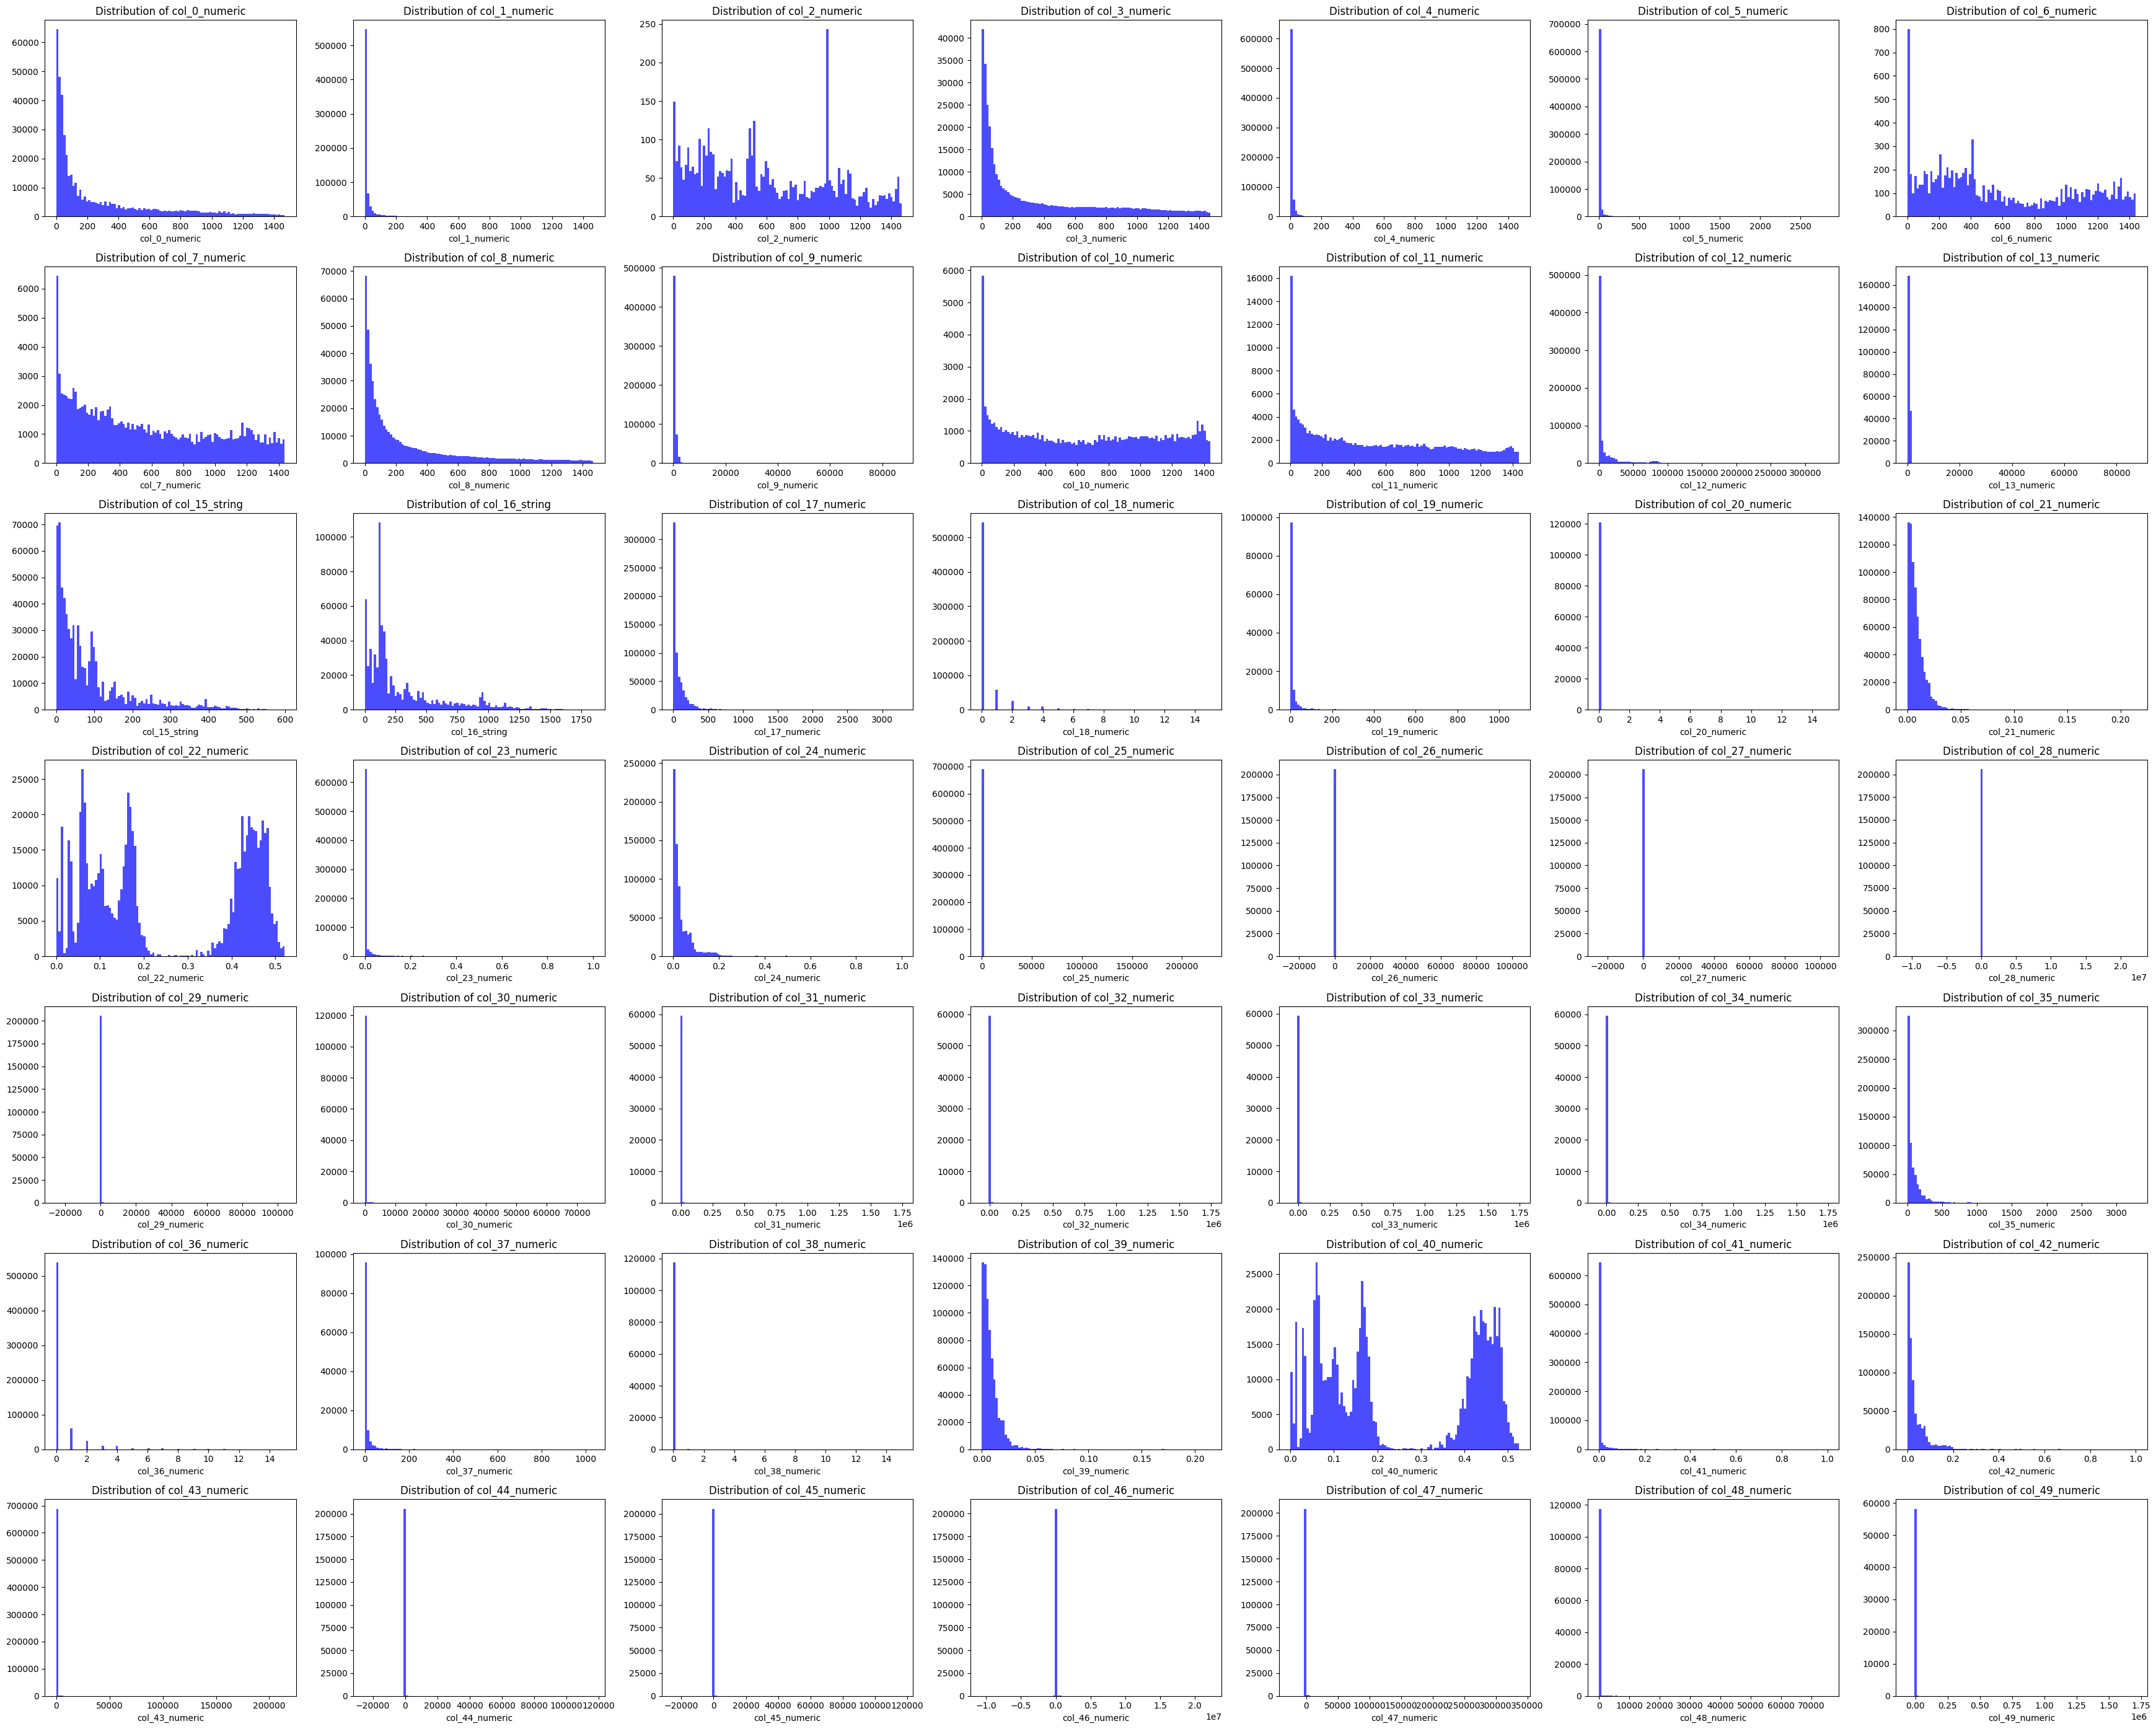

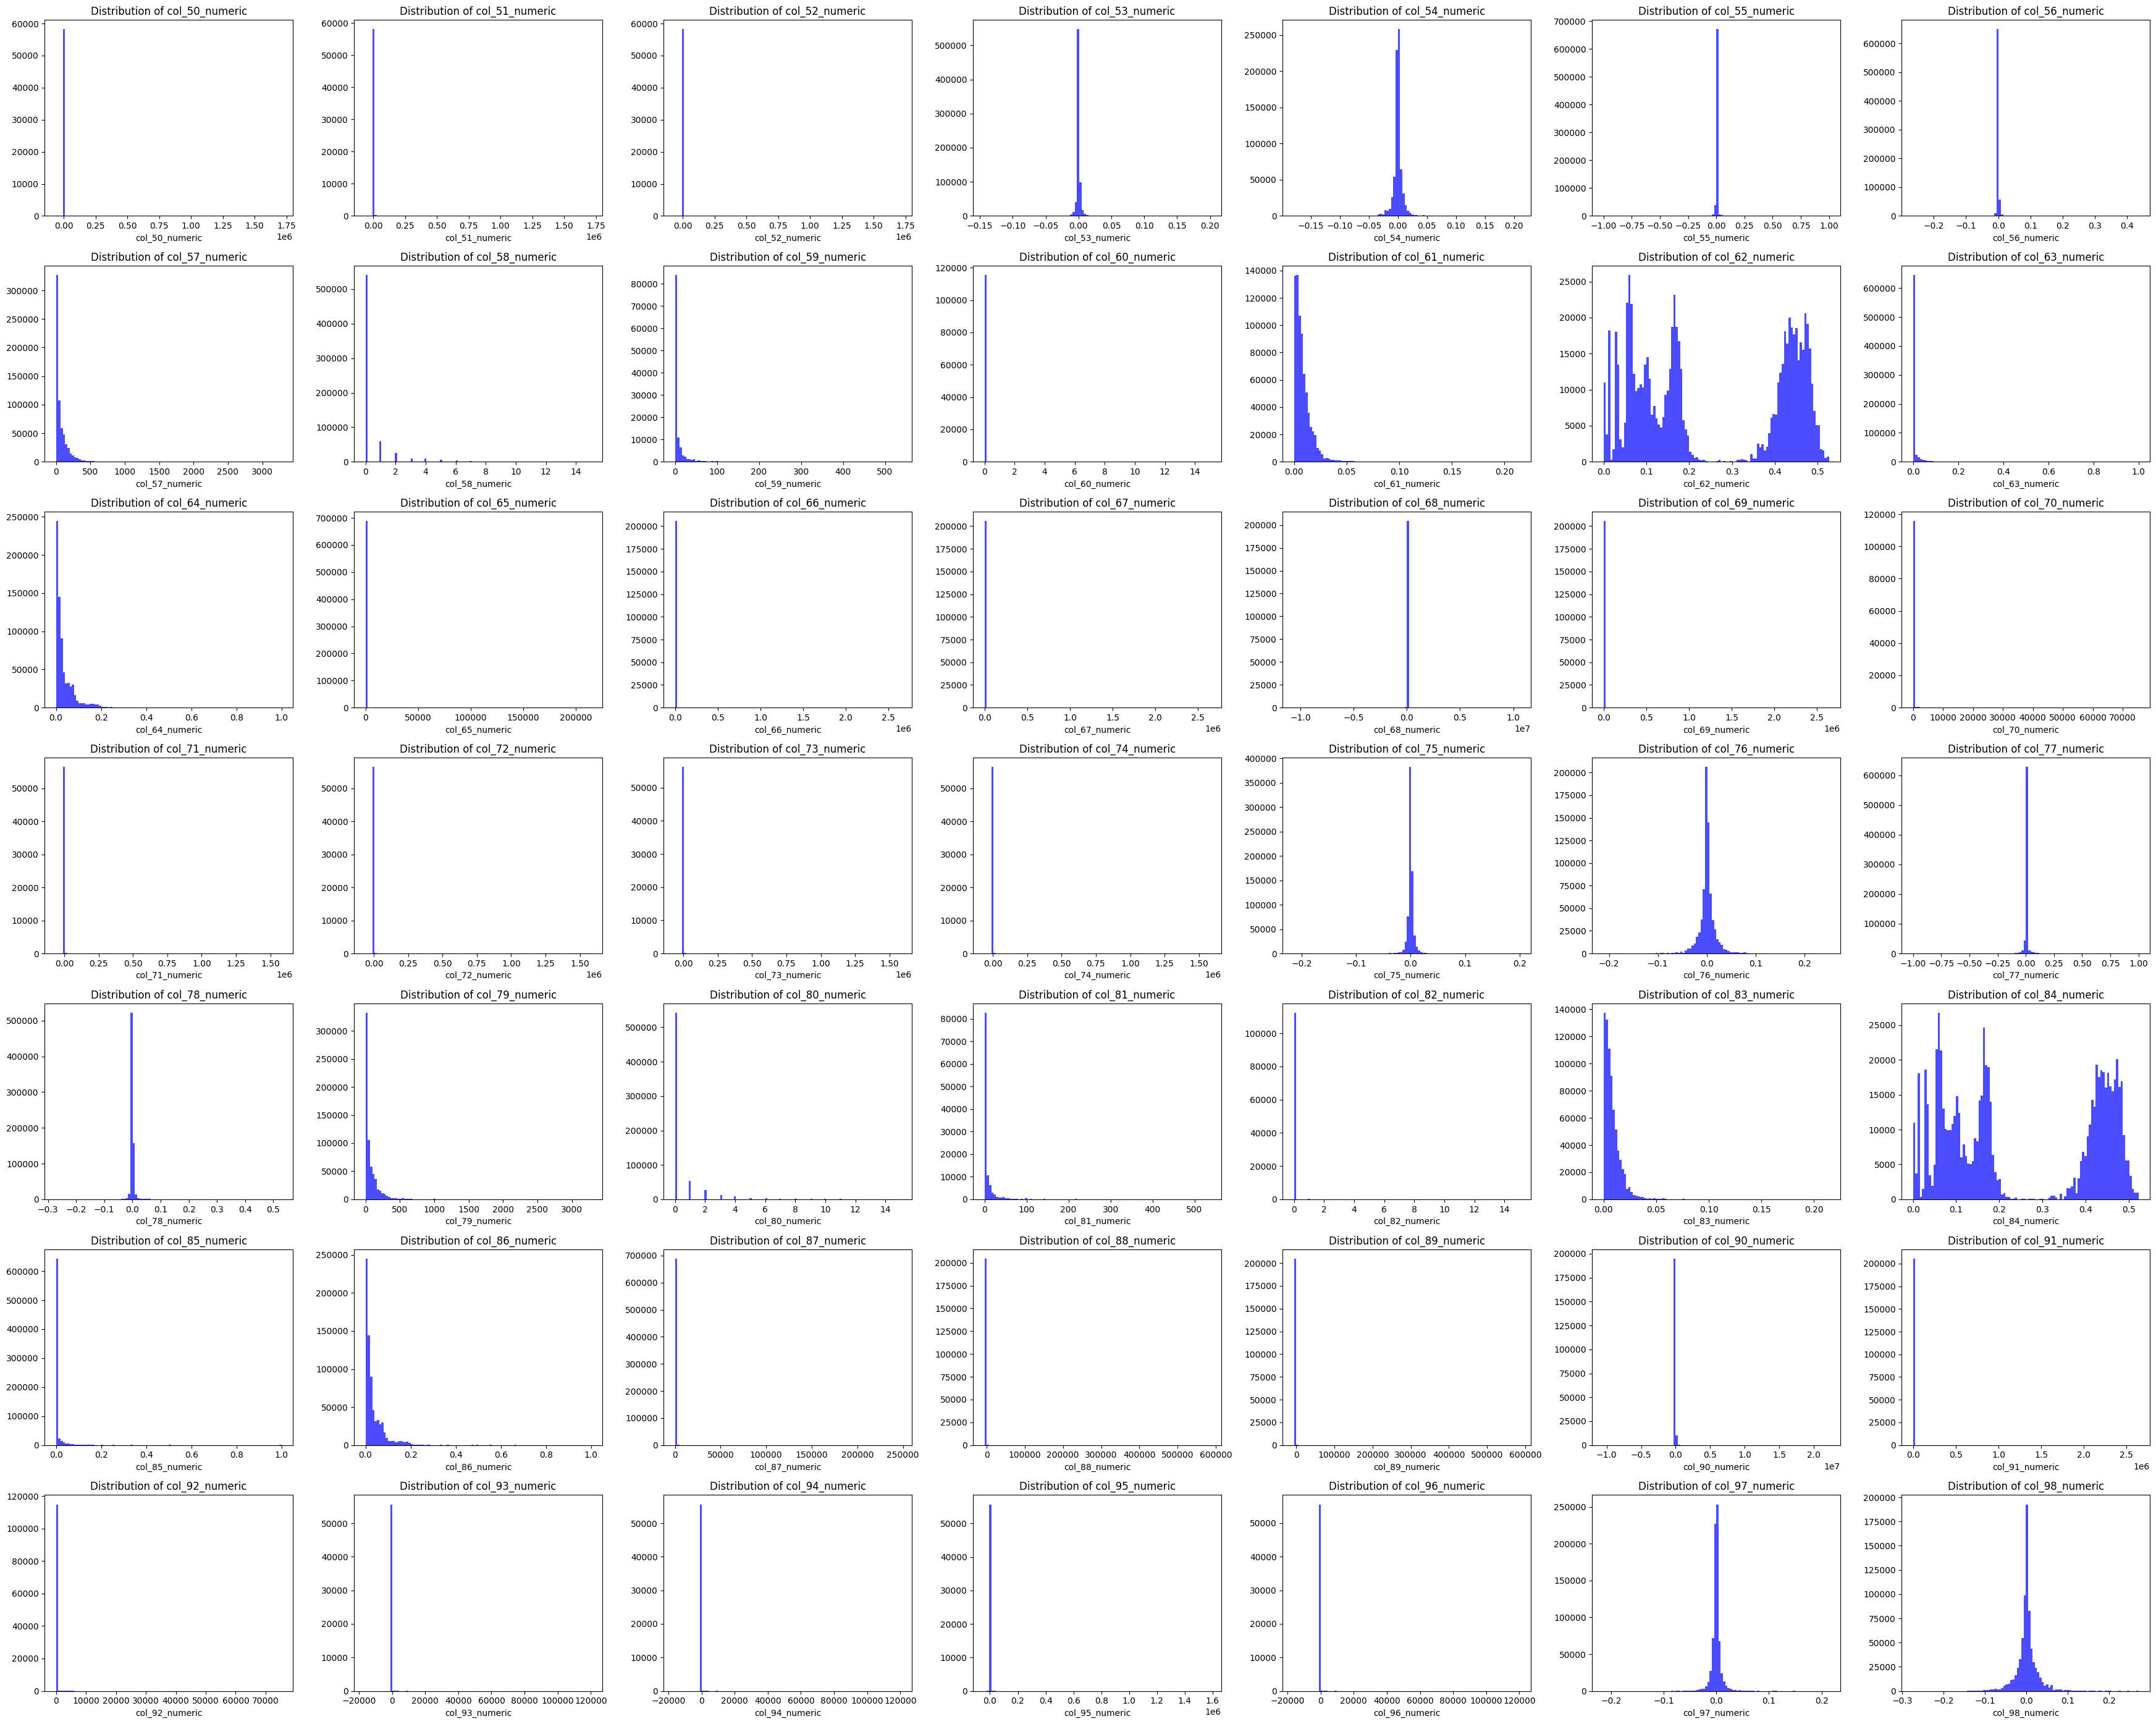

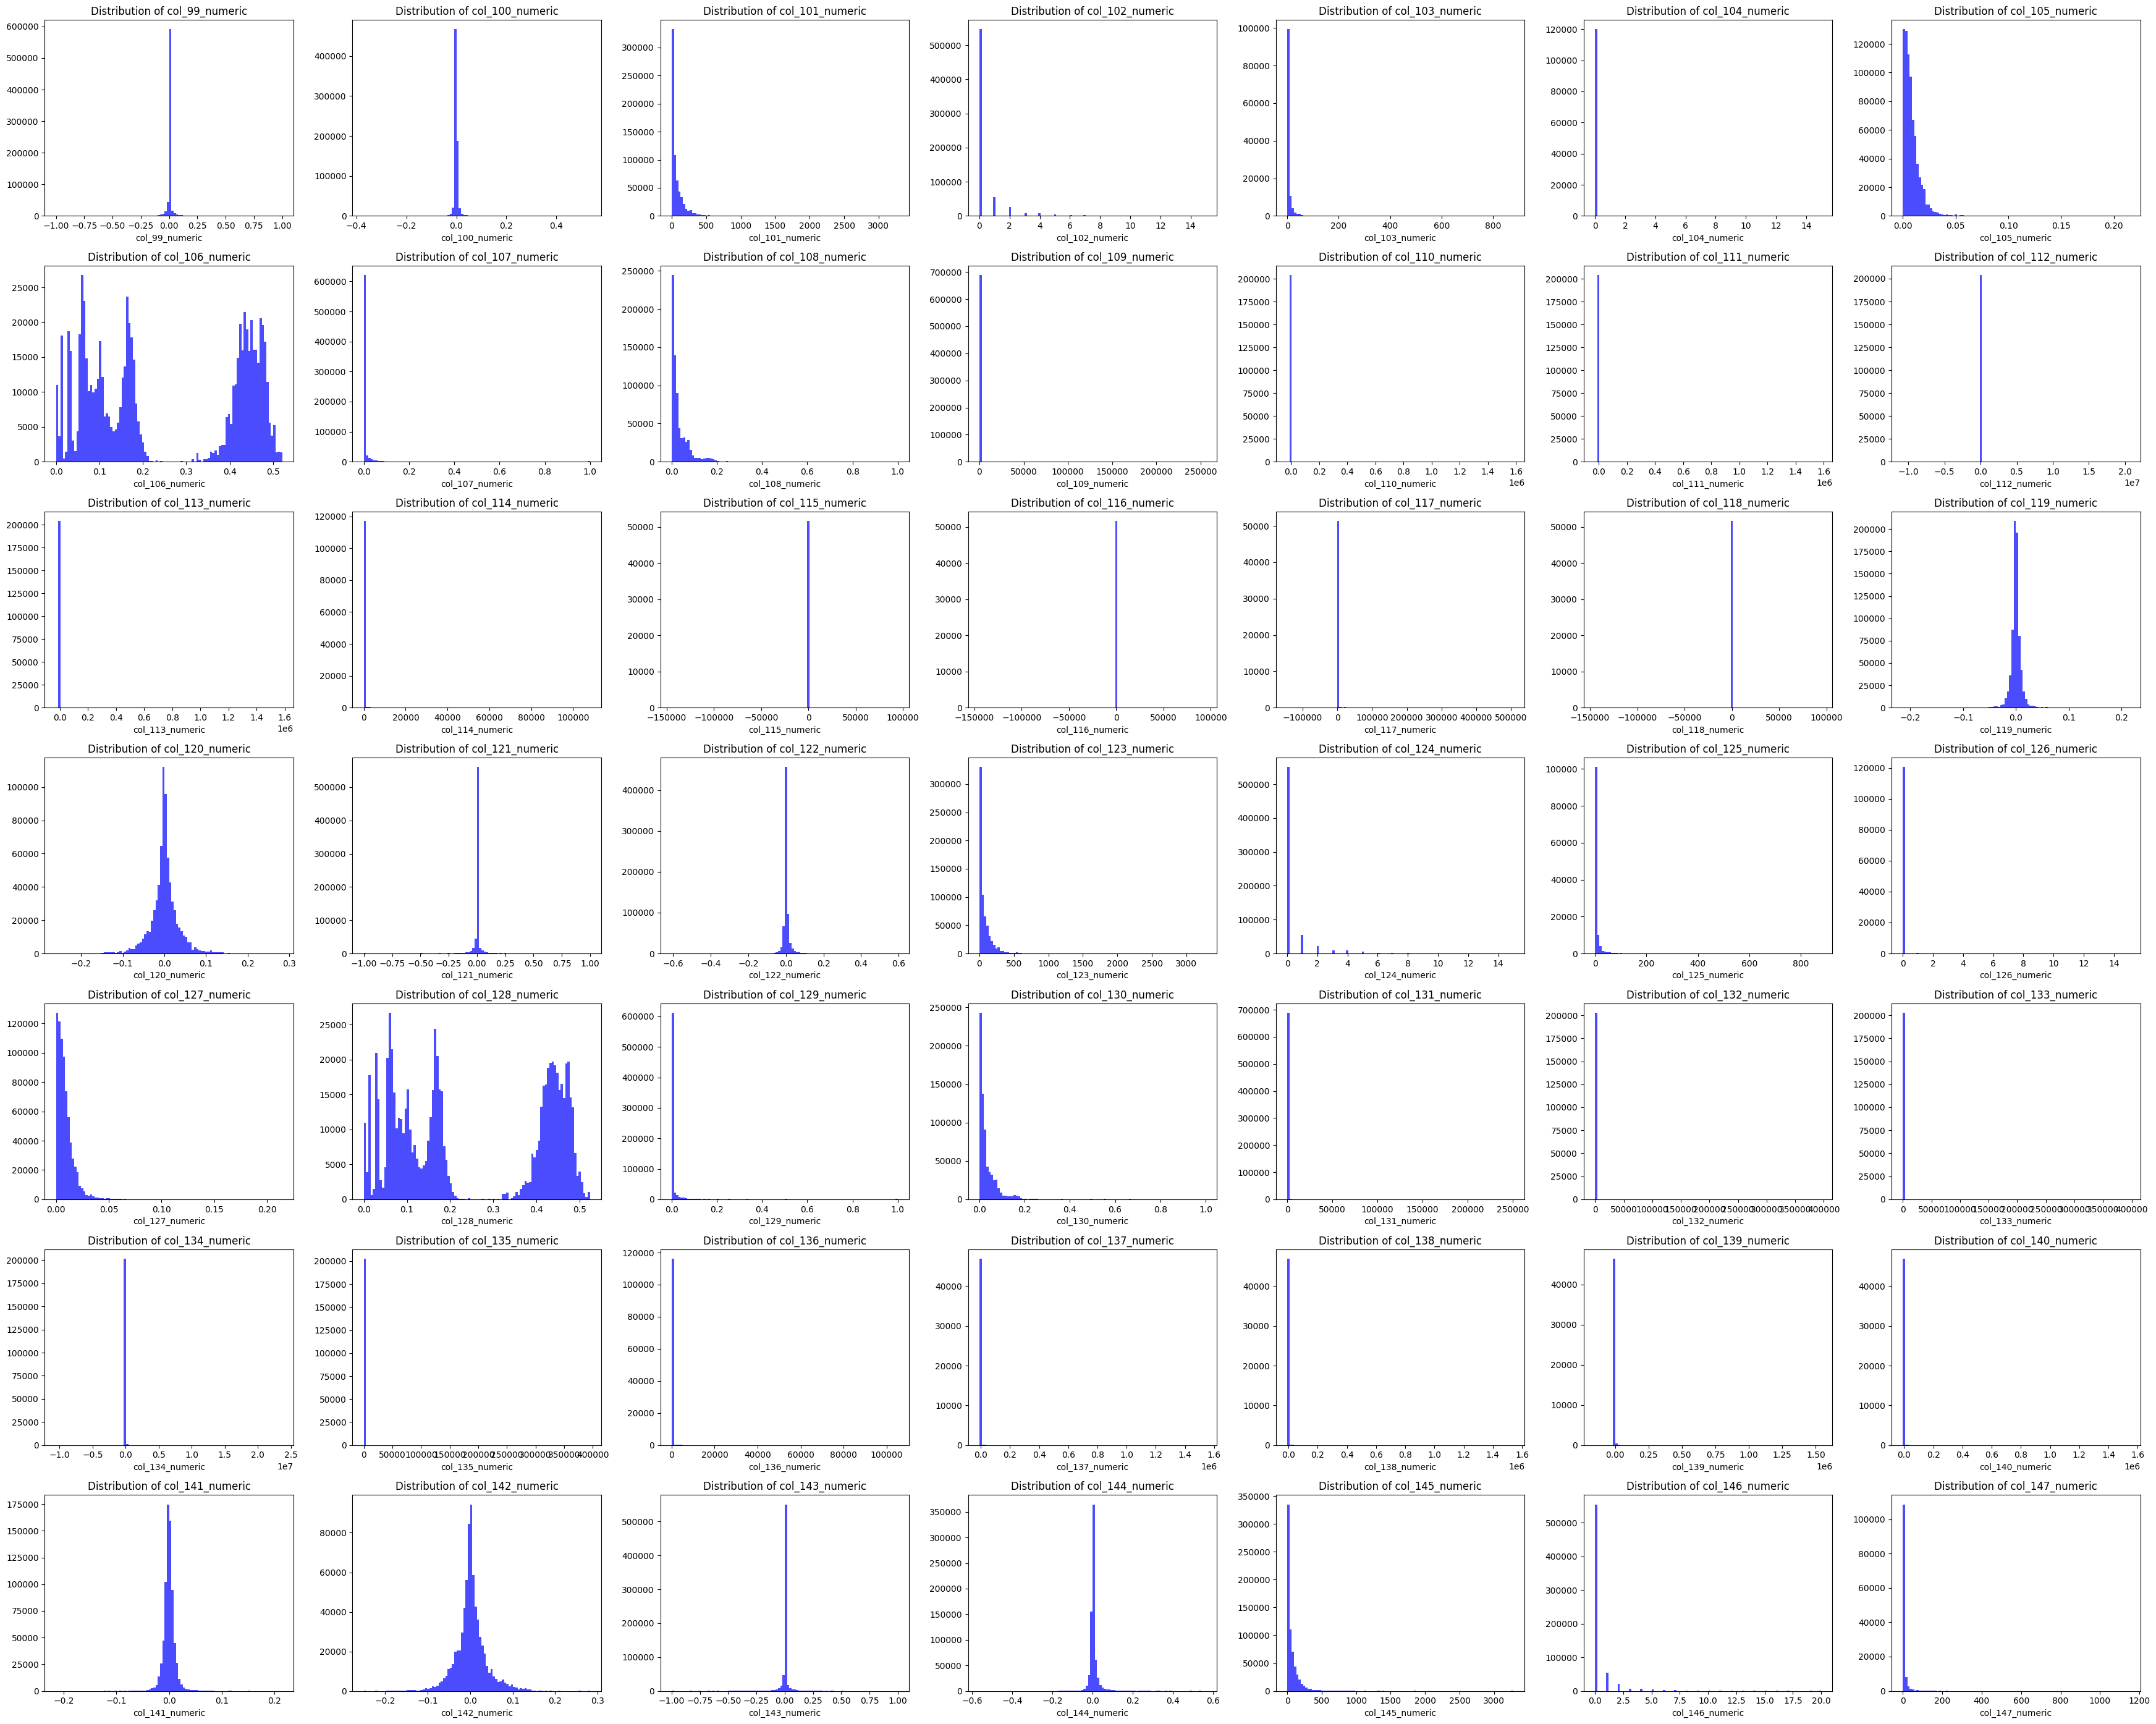

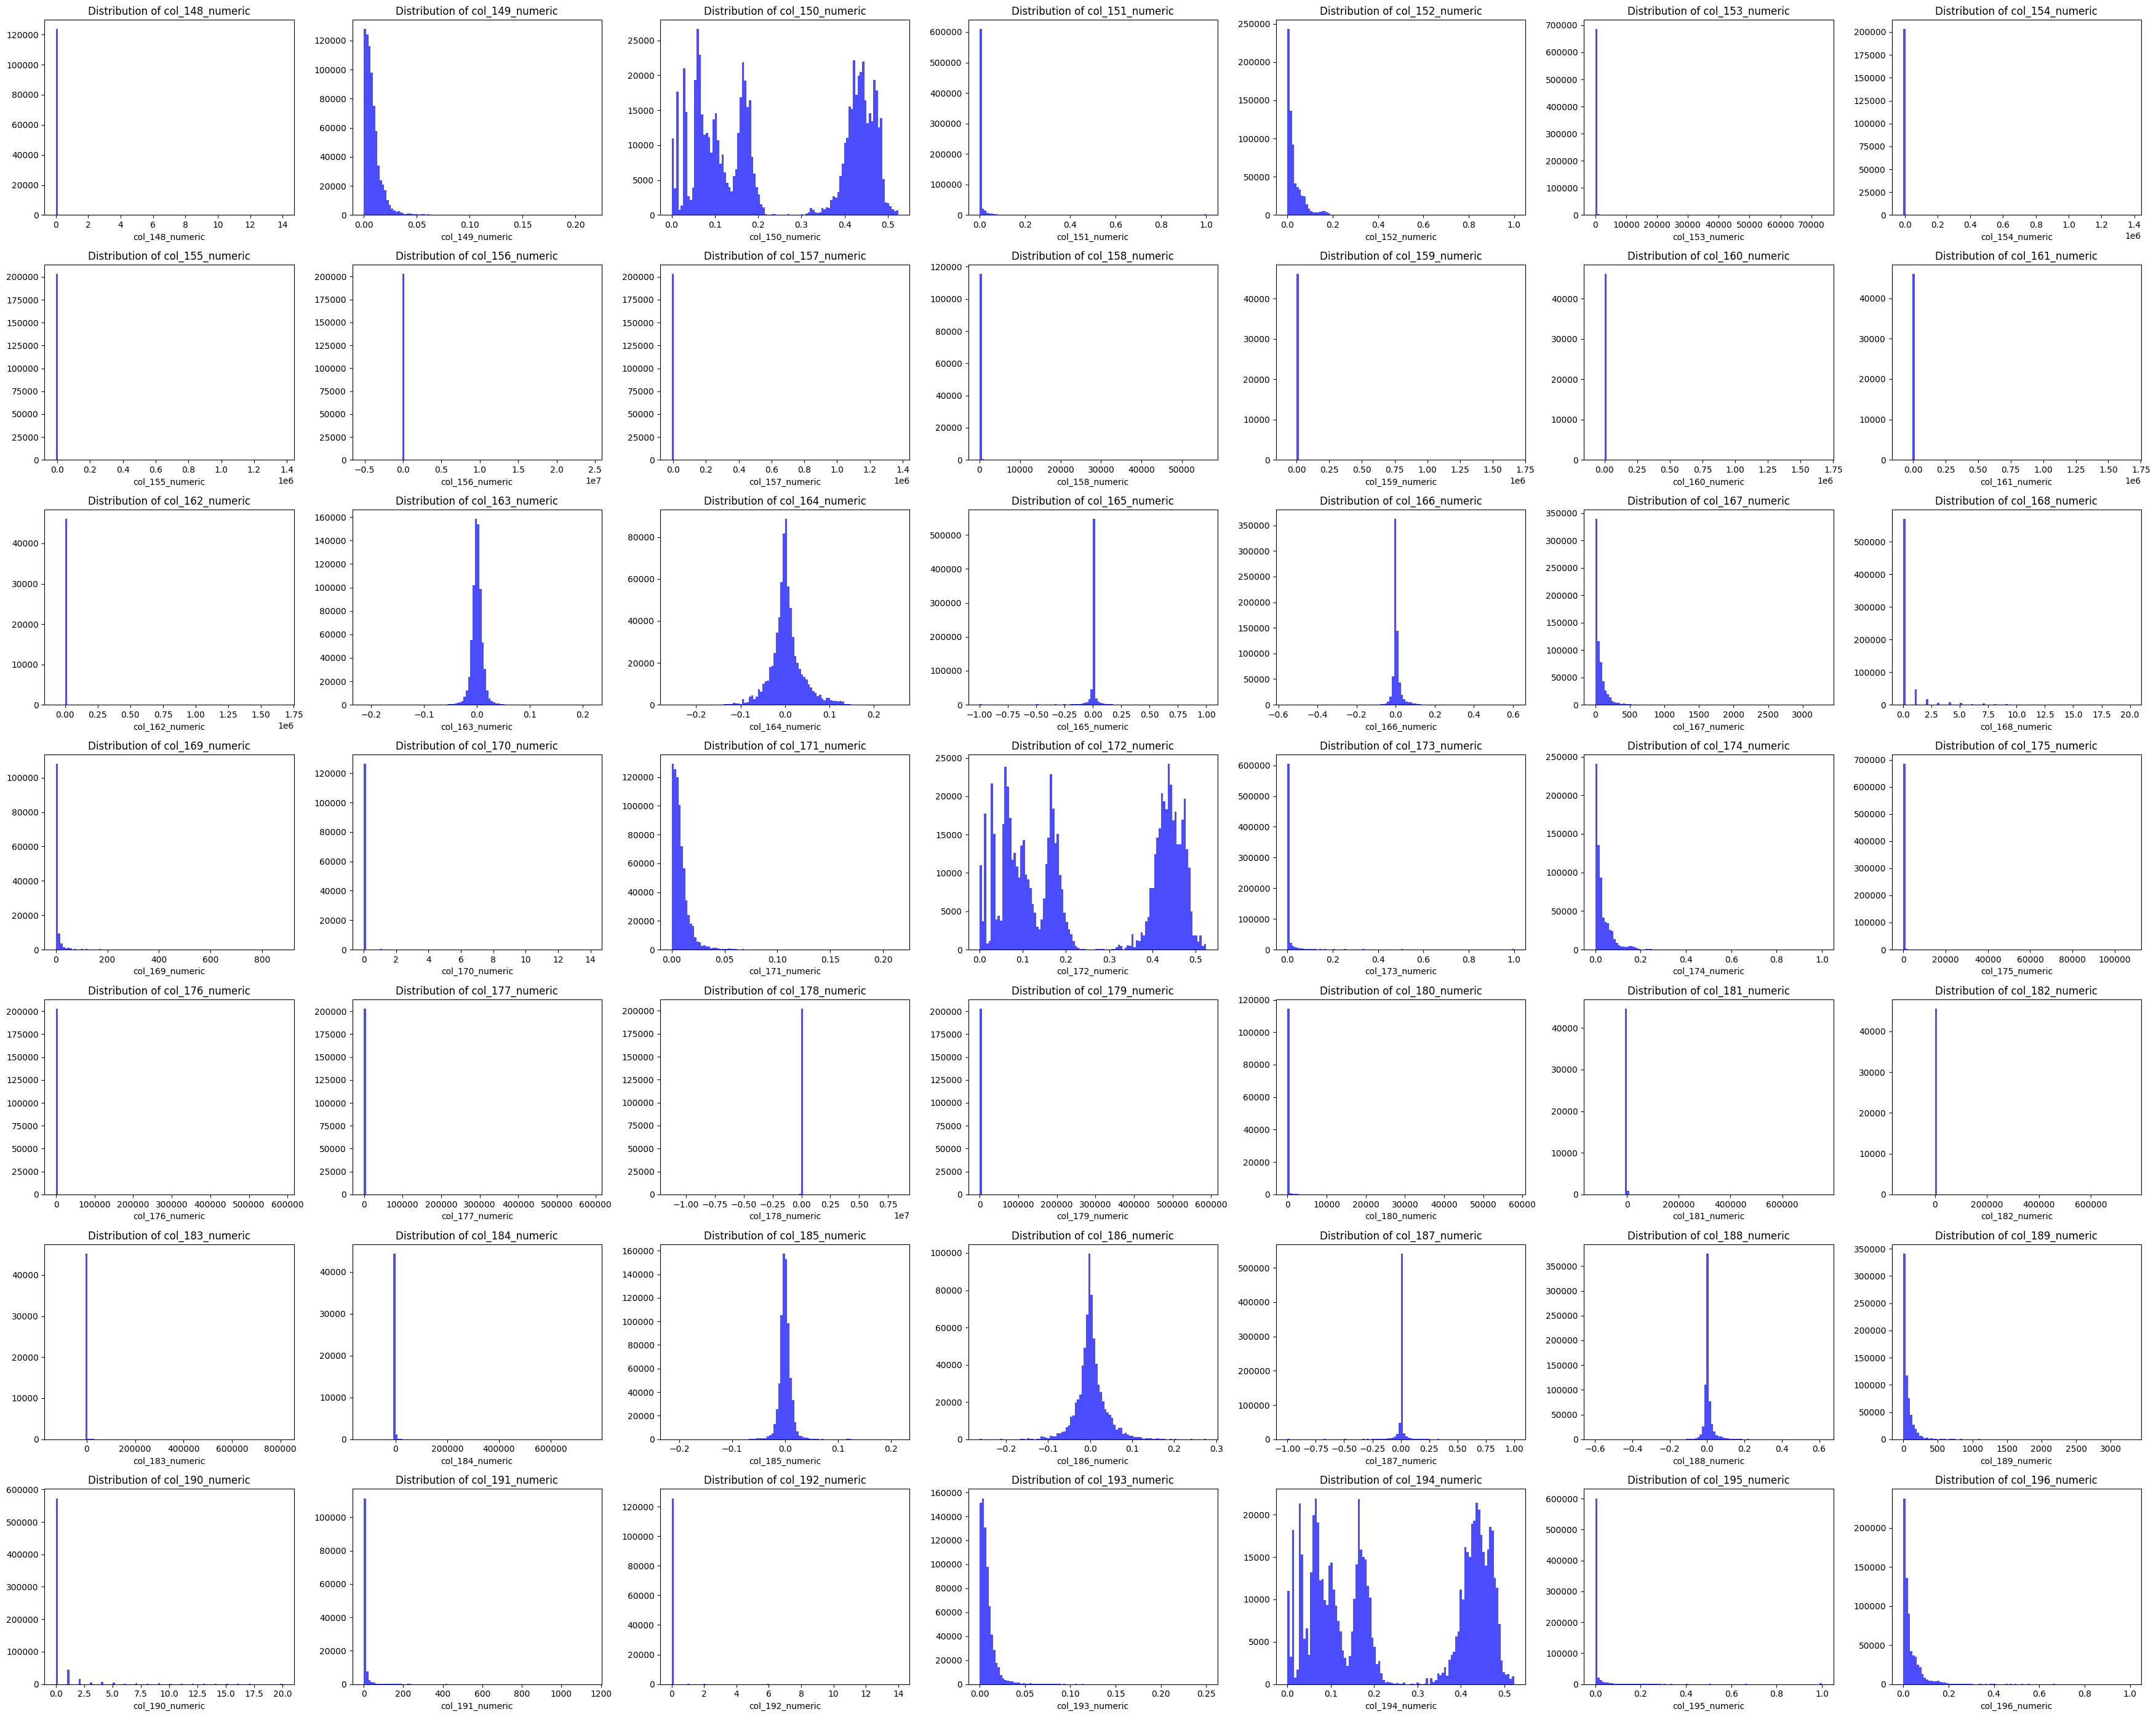

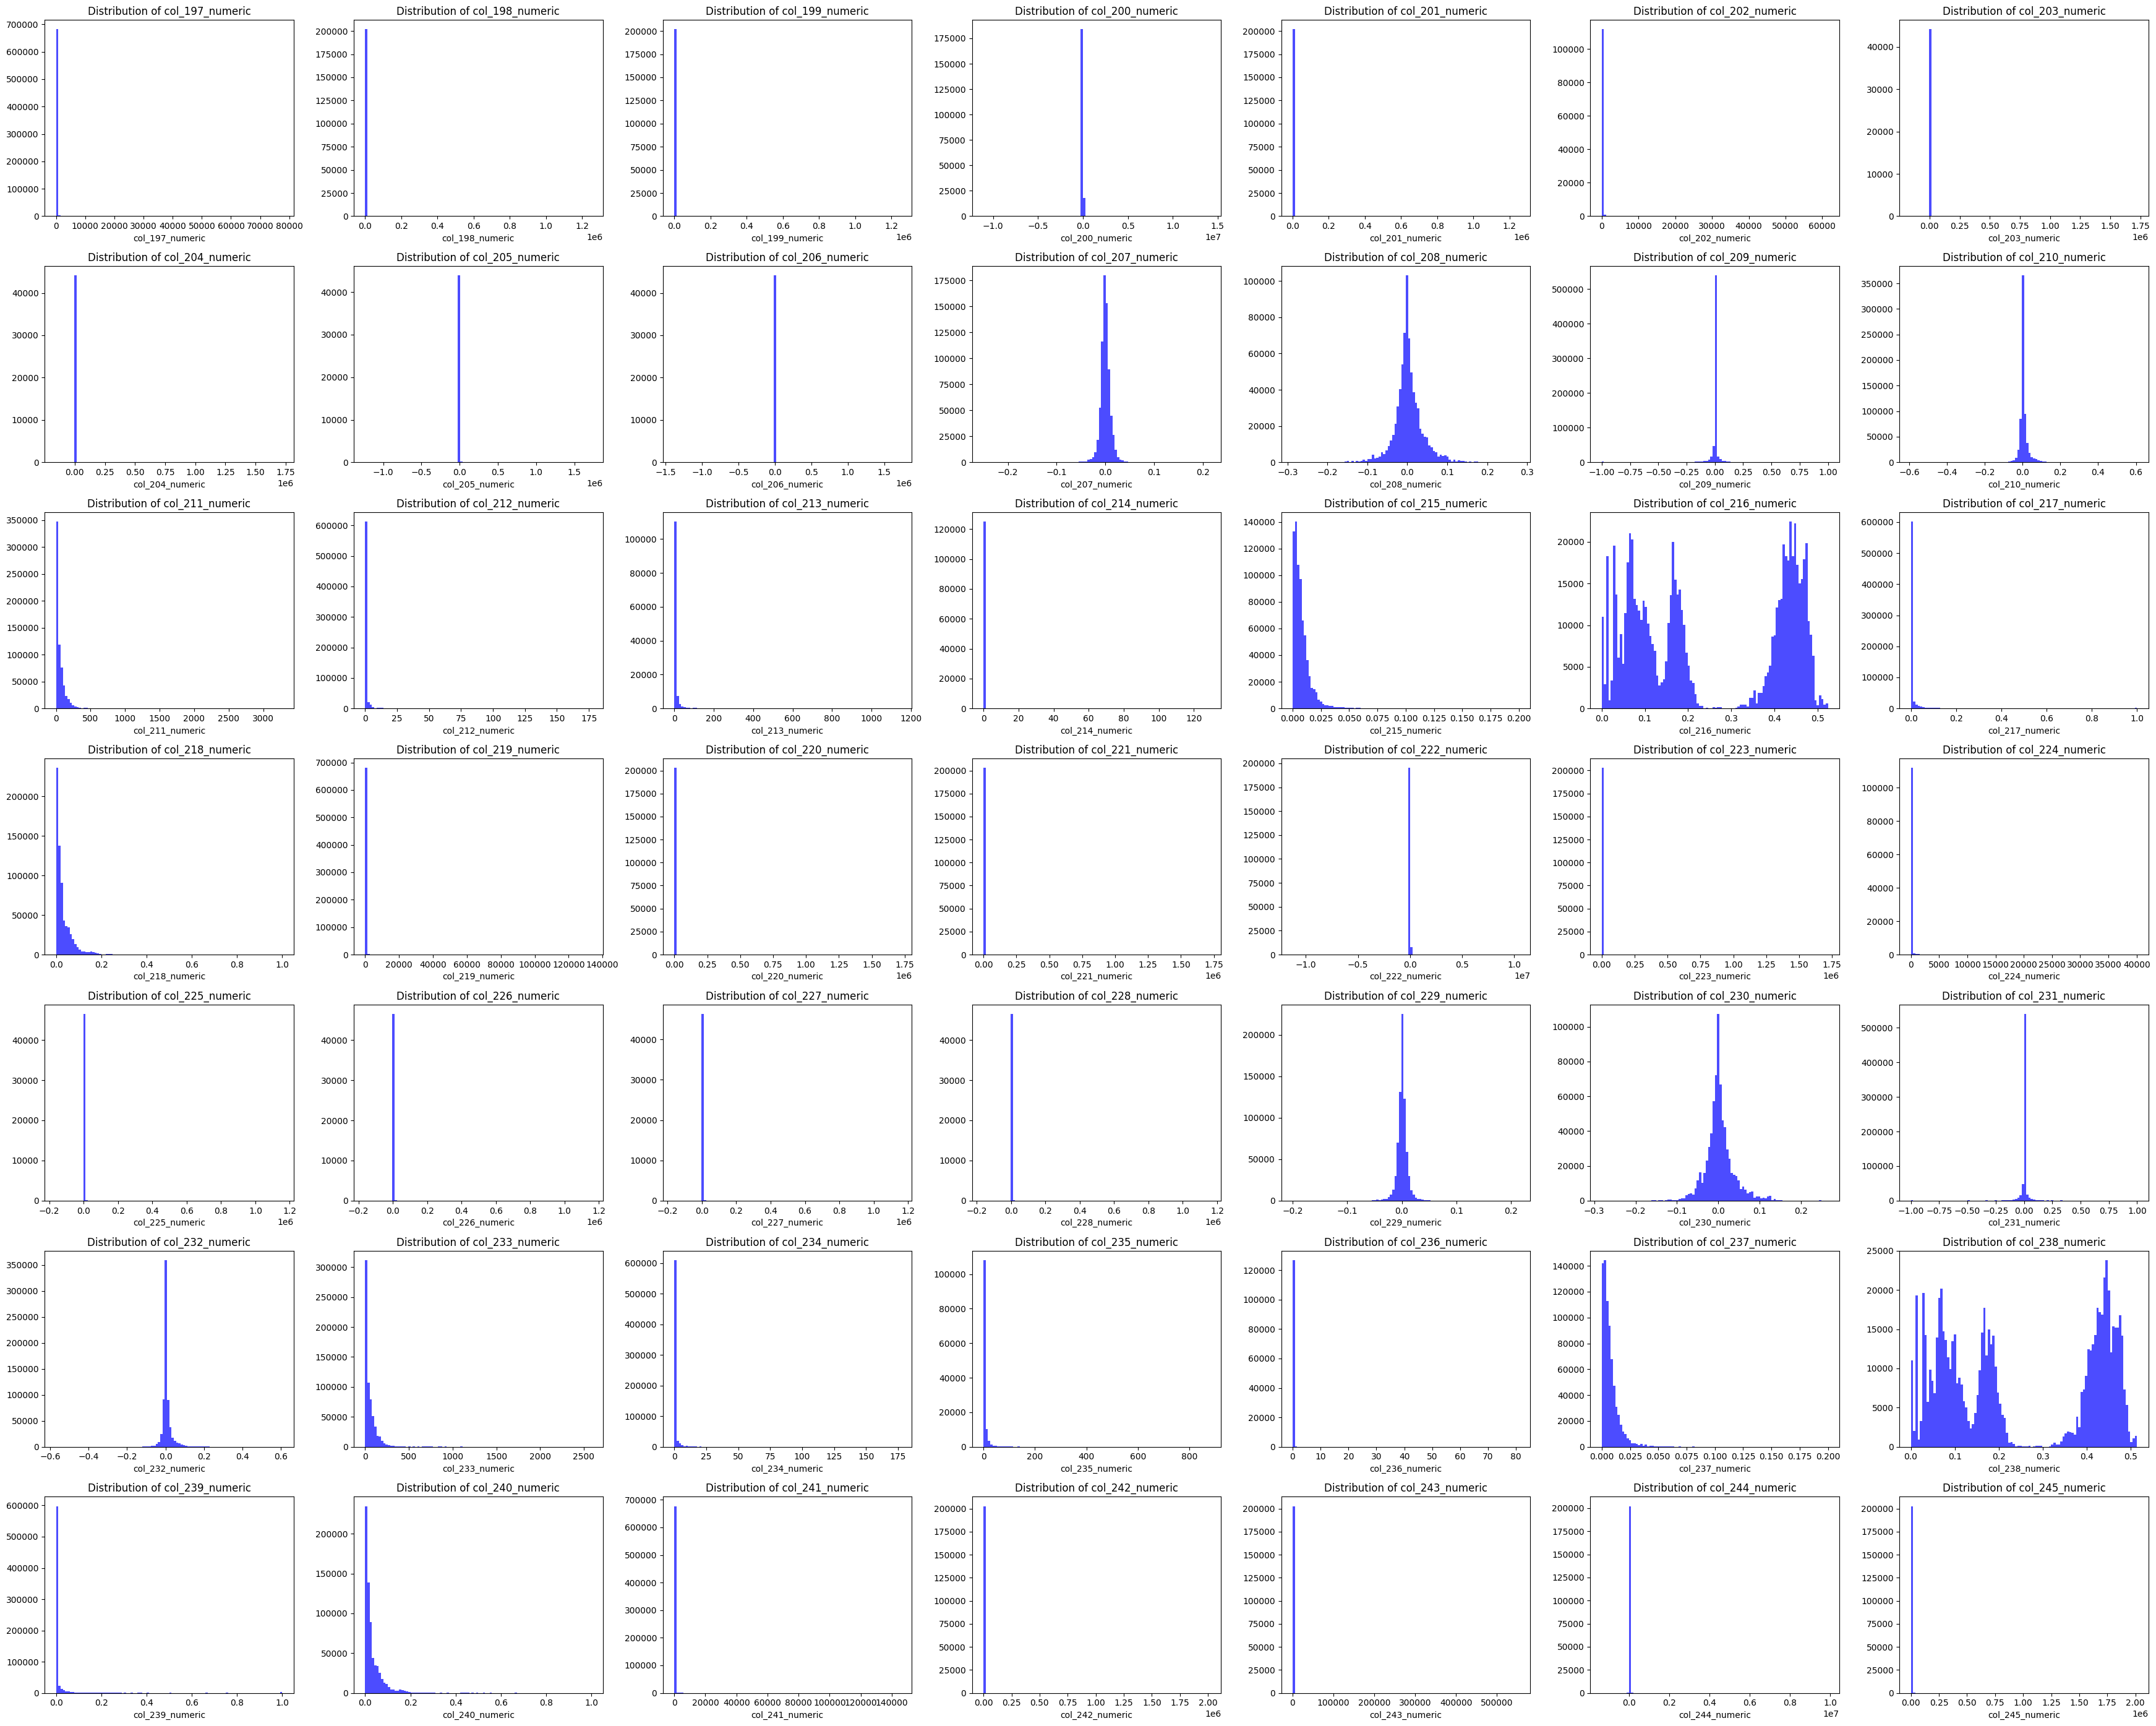

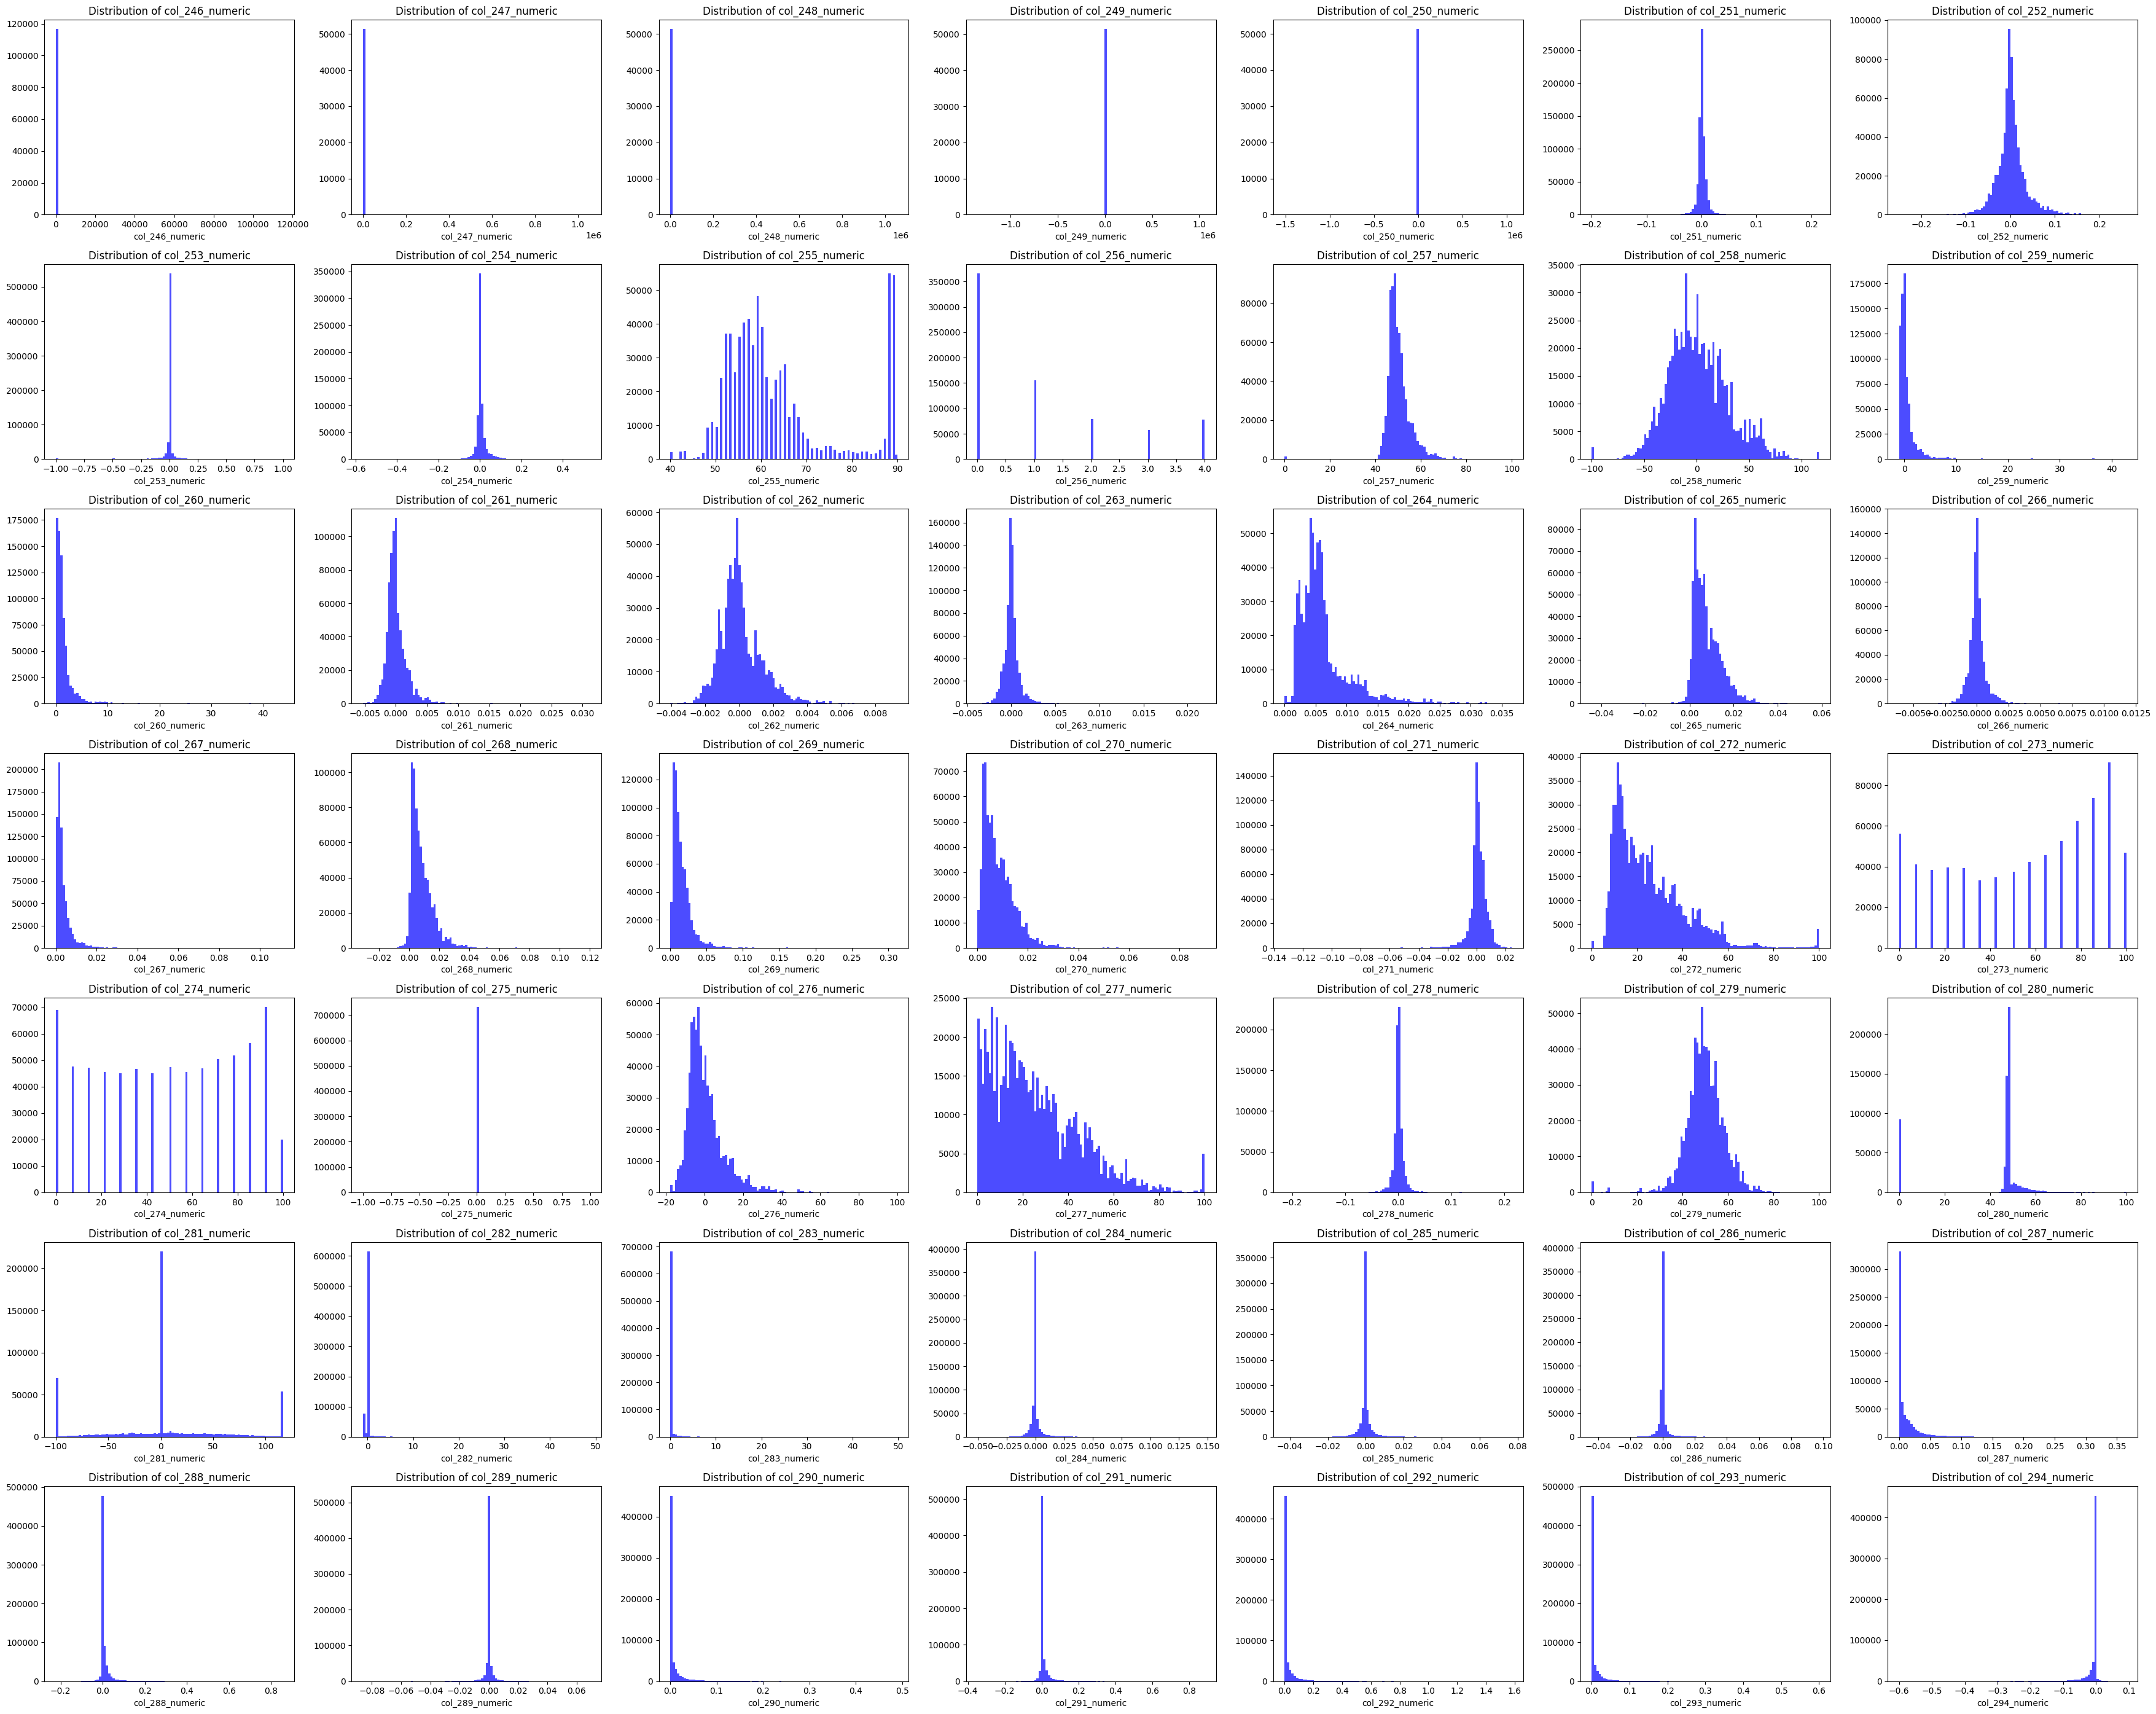

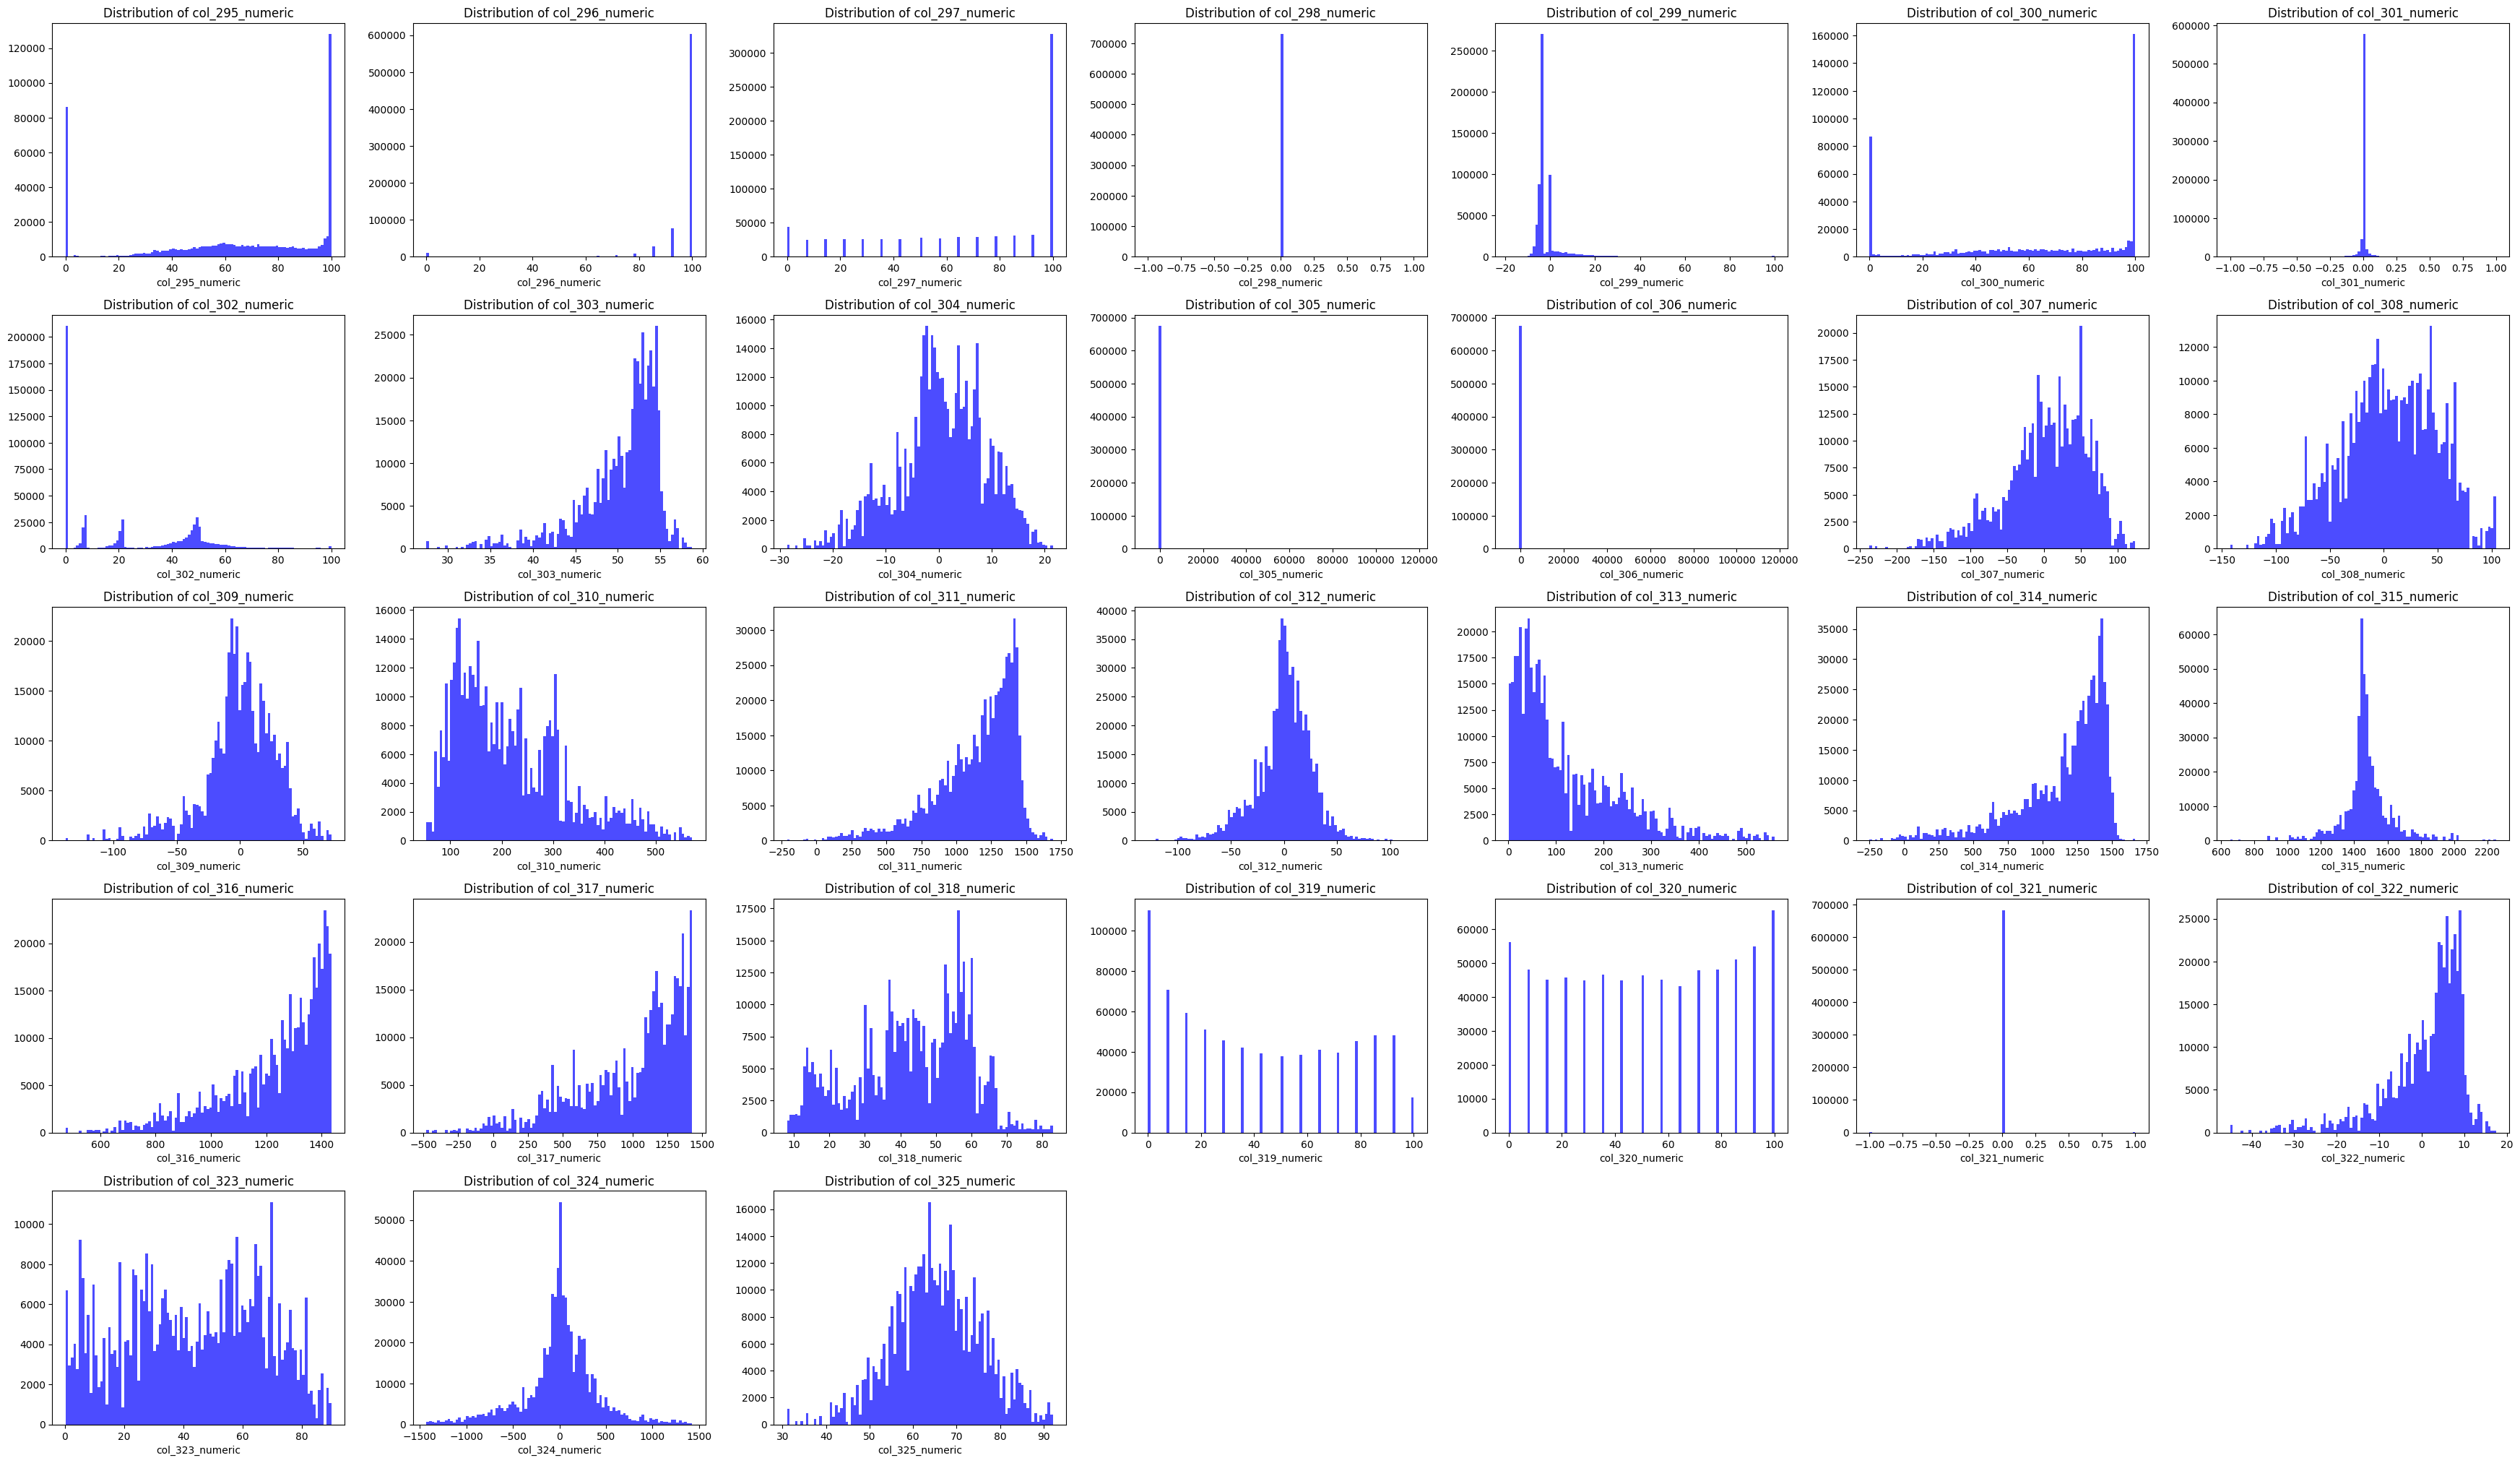

c:\Users\vctrg\OneDrive\Documents\Github\CastAITask\src\utils\EDA.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=self.df[col], ax=ax, palette='viridis', order=self.df[col].value_counts().index[:10])
c:\Users\vctrg\OneDrive\Documents\Github\CastAITask\src\utils\EDA.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=self.df[col], ax=ax, palette='viridis', order=self.df[col].value_counts().index[:10])


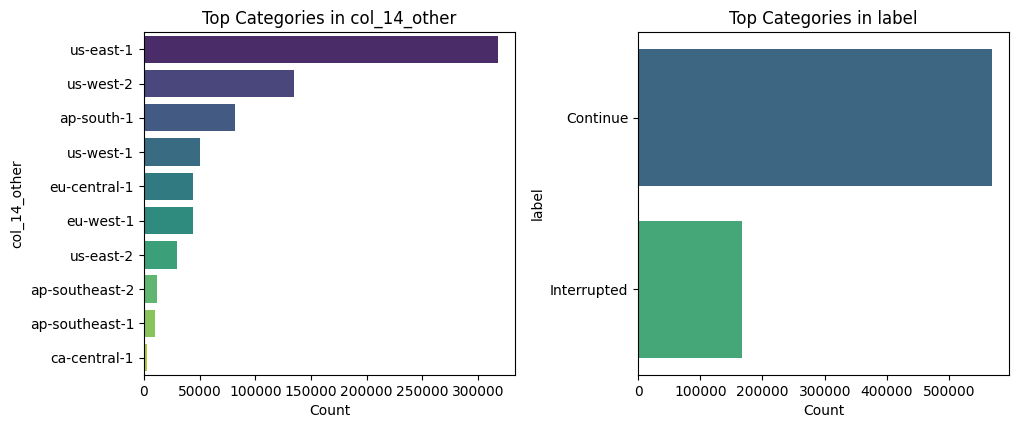

In [64]:
eda.plot_features(grid_size=(7,7), n_bins=100)


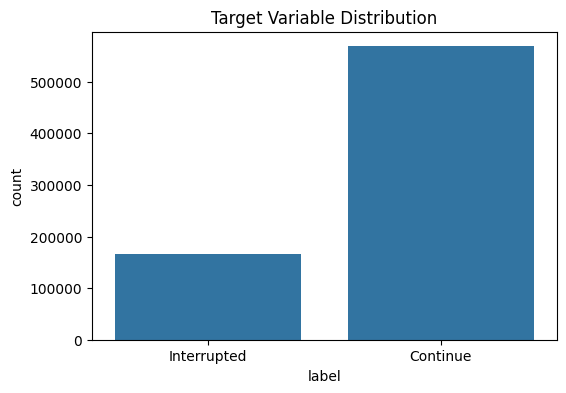

In [9]:
eda.target_distribution()

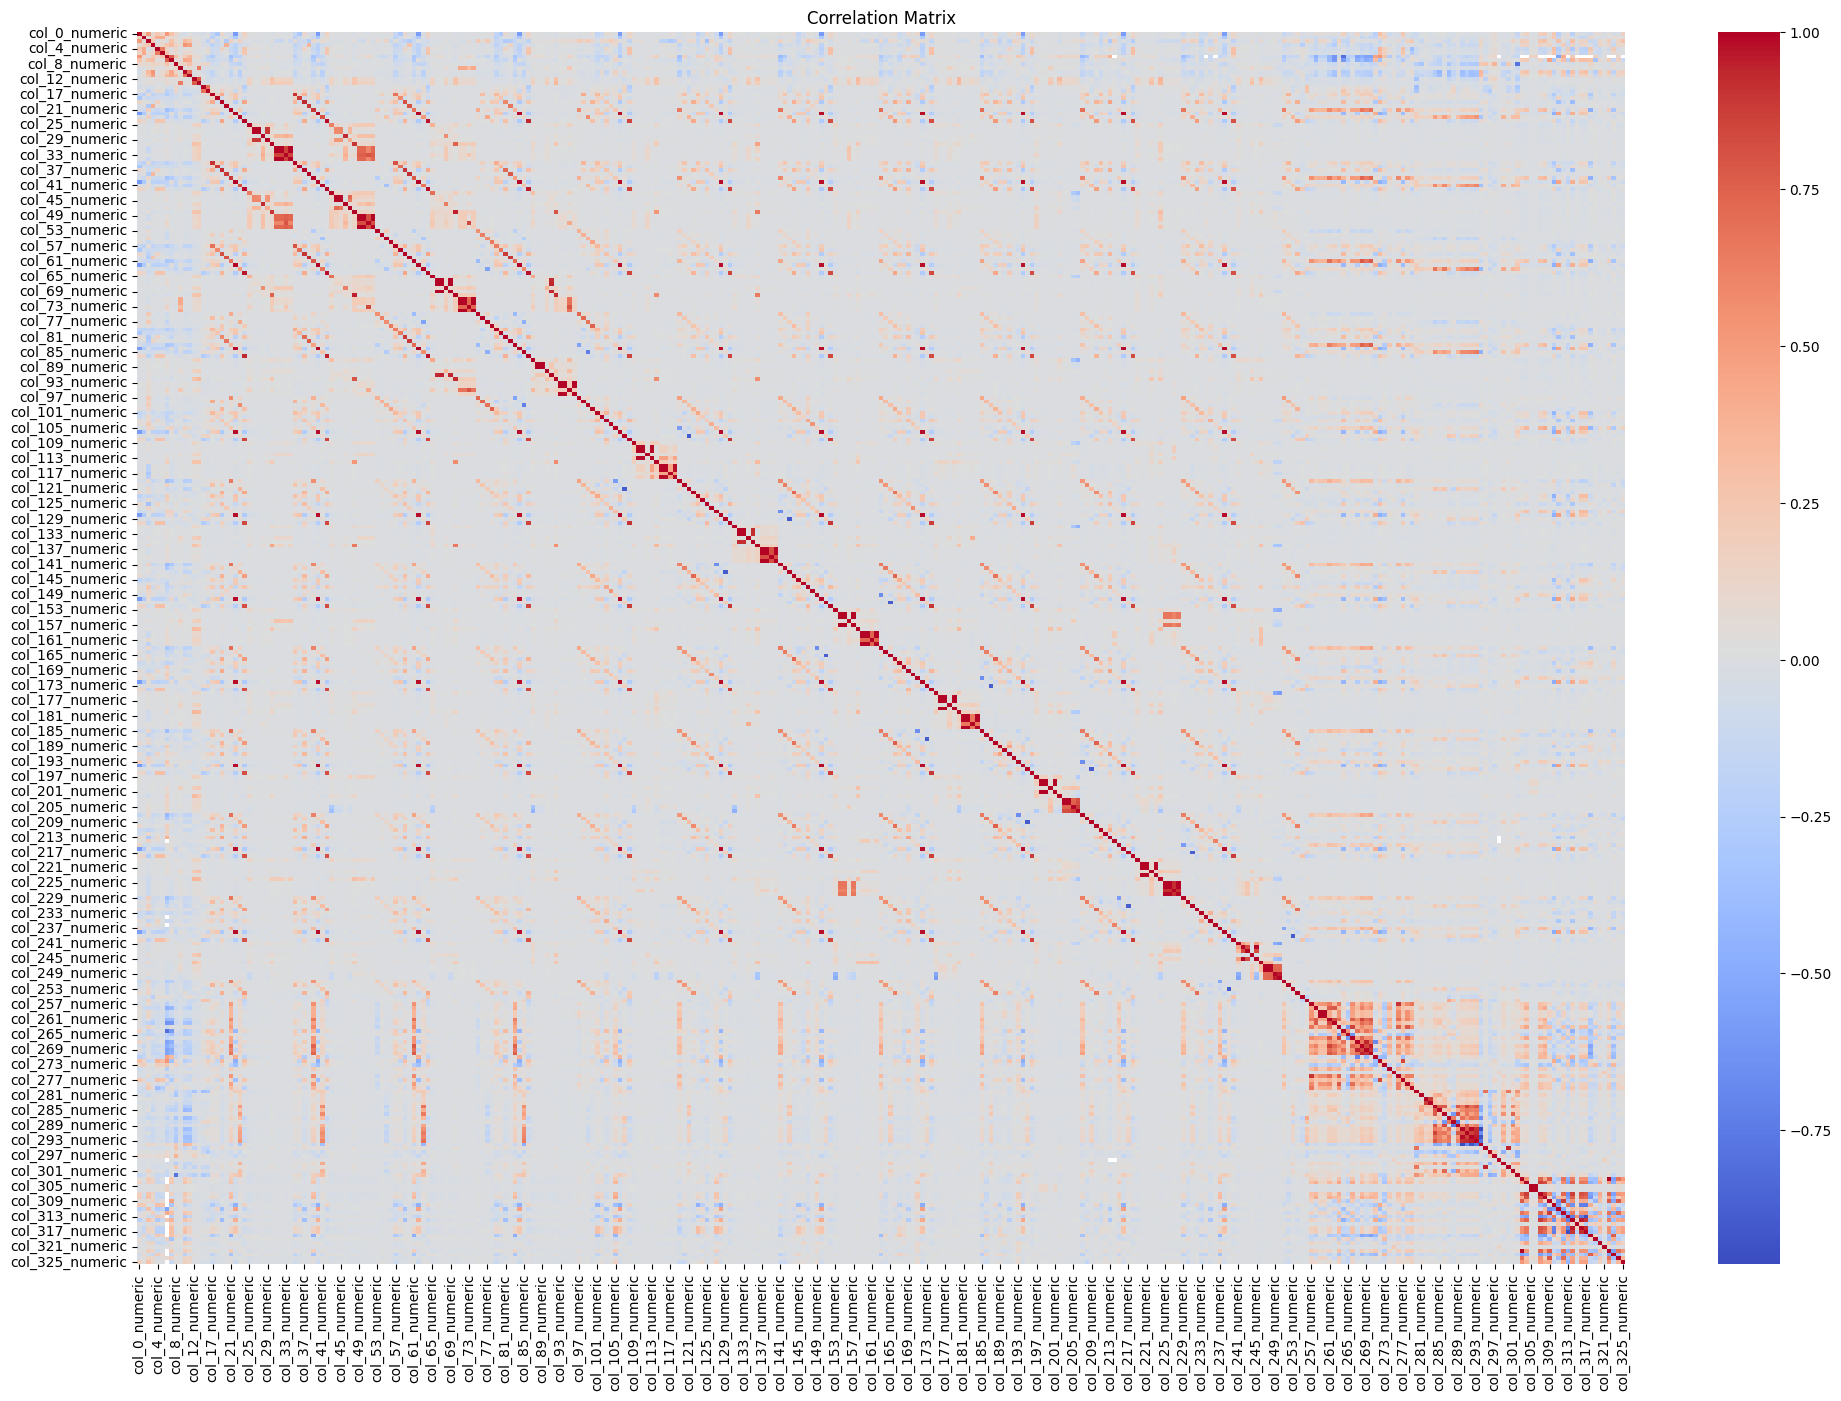

In [18]:
eda.correlation_matrix()

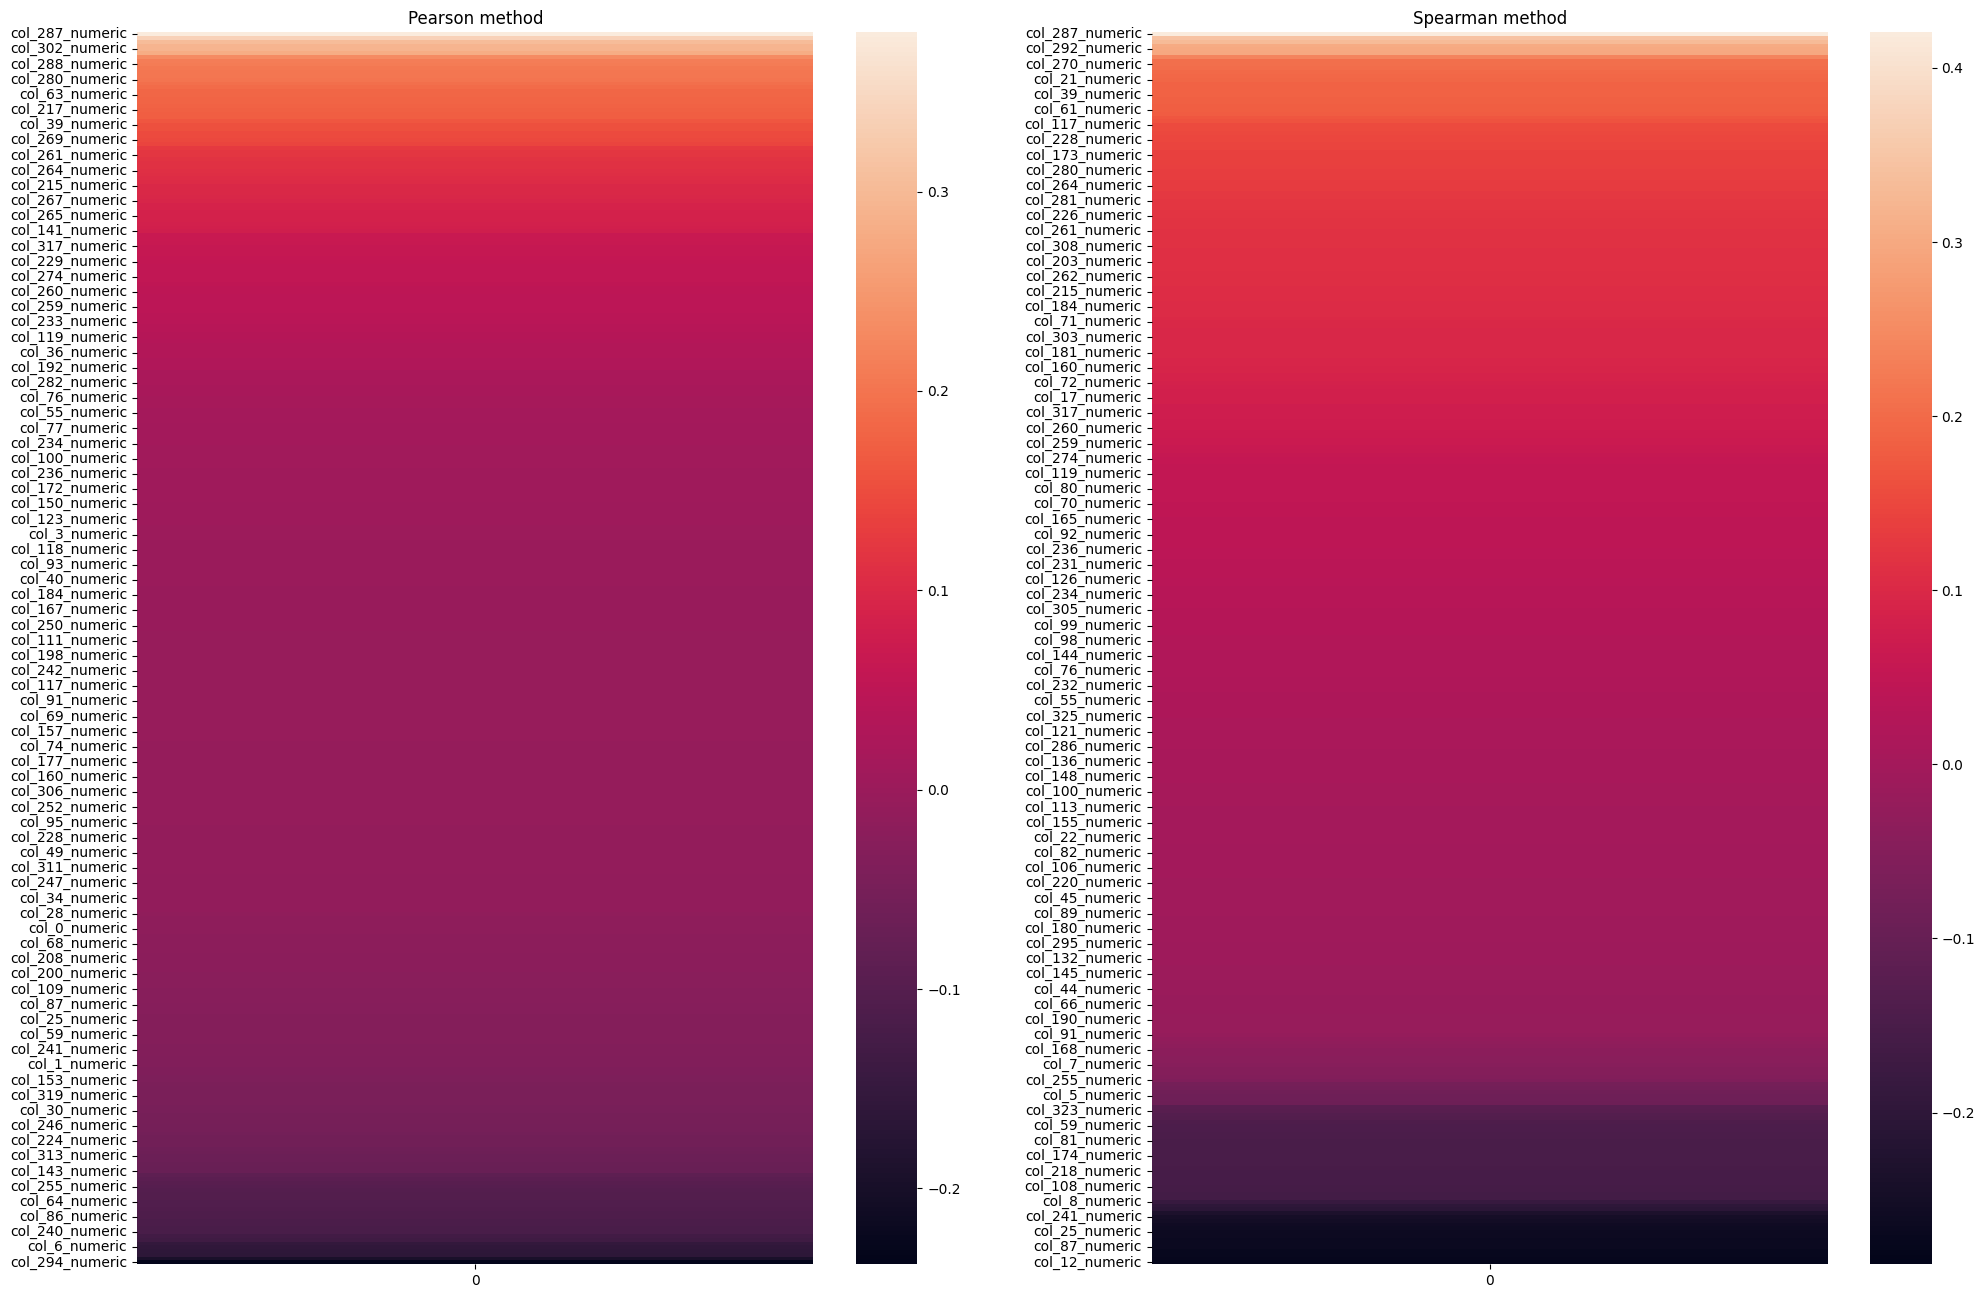

In [85]:
eda.target_correlations()

#### PCA Analysis and Insights

Below we see the results of a quick PCA analysis without any prior preprocessing or transformations (as discussed, we might benefit from log/quantile/power transformations). Nevertheless, we do notice some interesting behaviours:

- **The explained variance:** While somewhat expected, the explained variance quickly diminishes in increasing explained variance per added PCA component. If we set a 90% threshold on the explained variance, so as to gauge how many components we would need to roughly explain the data, we see that we would require ~100 PCA components, which is non-trivial, although it is still a 60-70% reduction in the dataset approximately, which is still a great gain in terms of computational performance, while giving us the desired multicollinearity reduction that we would like to have.
- **The first 2 PCA components:** Unfortunately don't tell us that much, since on top of large saturation of explained variance per component, we also see that first and second principle components only account for ~15-17% of the explained variance together, and so it is perhaps normal to see that they aren't entirely distinct when plotting data points.
- **The loadings of the PCA components:** These tell us the correlation of the PCA component against the raw feature of the original dataset. In short it tells us which features of the data are modelled by each PCA component, and greatly help us in being able to roughly explain what each PCA component represents in terms of derived features. However, here all our columns are anonymised and we don't have a data schema, so we can't really get to that level of explainability that we would normally be able to do. Given the large amounts of features, it would also be tedious, but if model performance justified it, and if the business use-case required such a high degree of explainability, it would likely warrant the effort. Now, what we see in our case is a reassurance that the PCA components are very distinct from one another despite each accounting for only a small portion of the explained variance. Looking out for specific groups columns from the correlation matrix that we knew were correlated to one another, we see that they are grouped into a single PCA component, which reassures us that the components are indeed orthogonal and that we likely have addressed the issue of multicollinearity in our data.

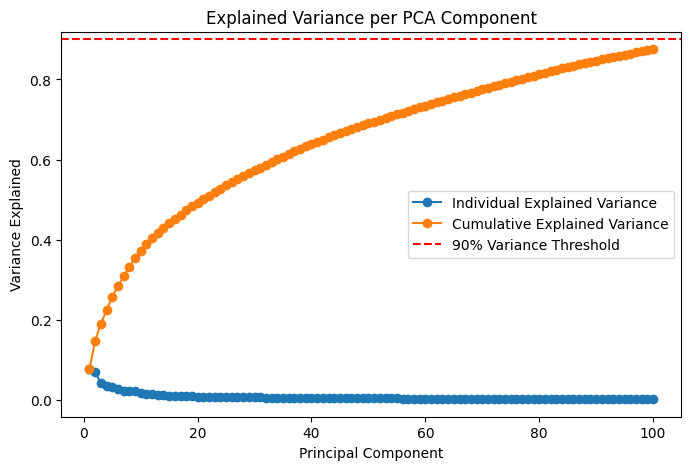

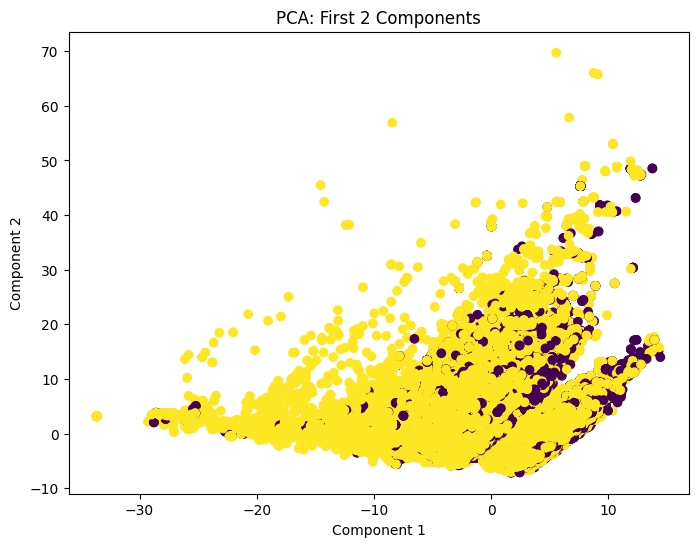

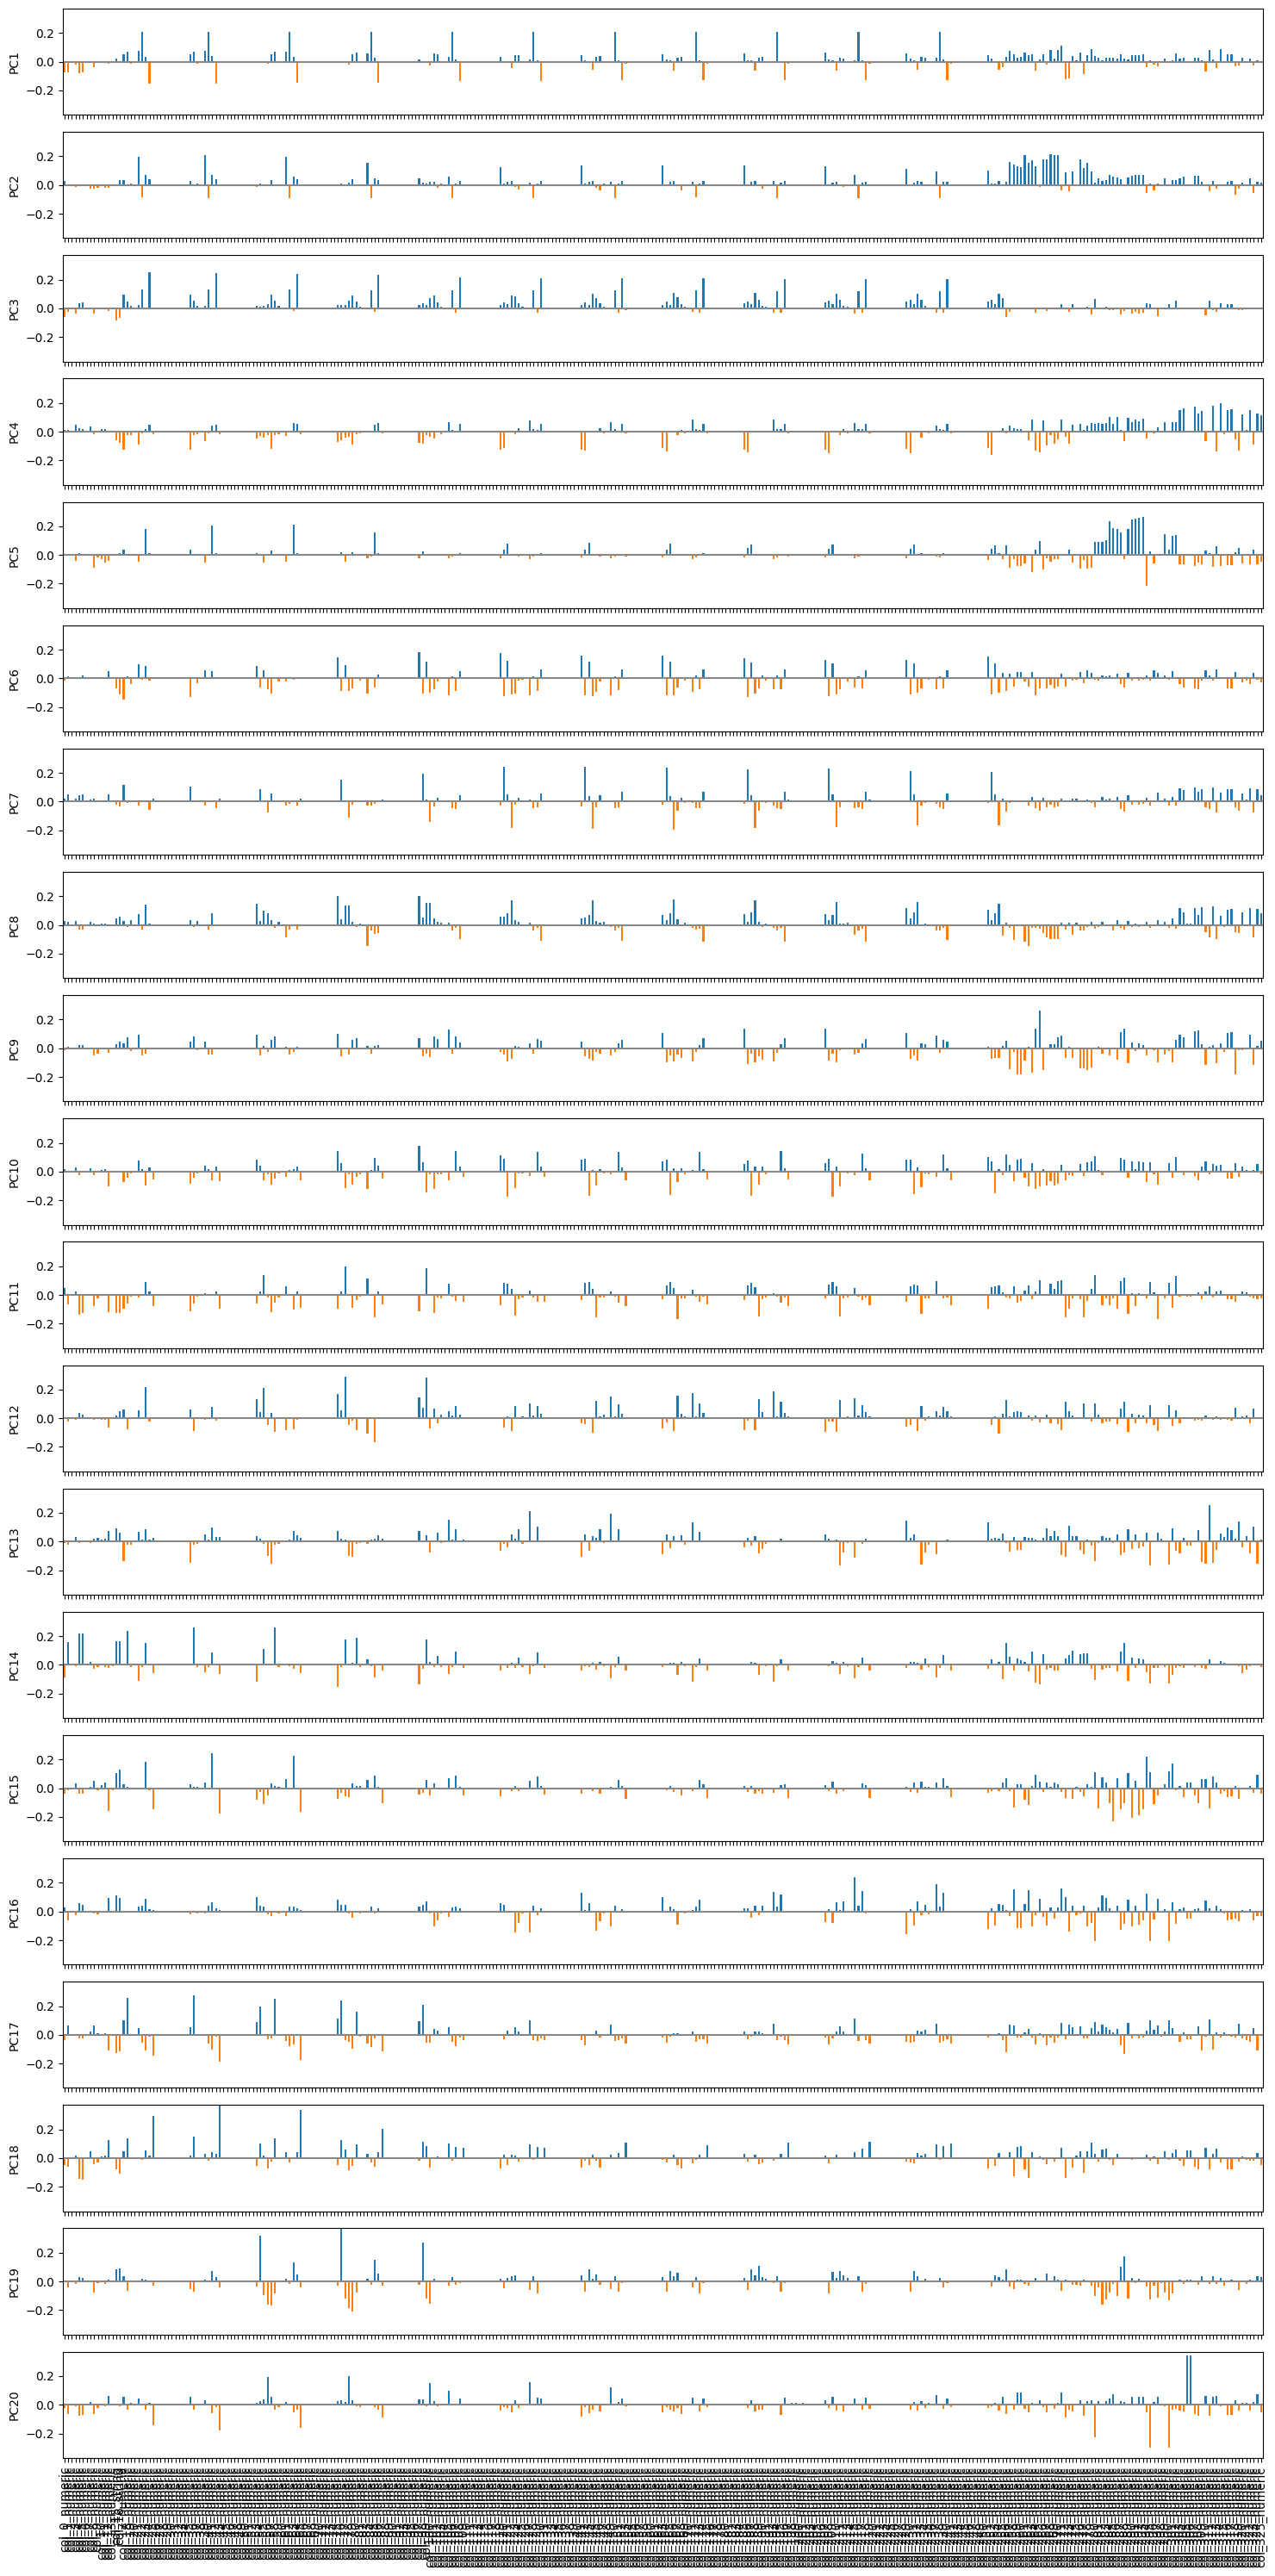

col_0_numeric  col_1_numeric  col_2_numeric  col_3_numeric  col_4_numeric  \
0       -0.075627      -0.071970       0.000200      -0.020645      -0.082175   
1        0.027826      -0.002236       0.000331      -0.012188      -0.005160   
2       -0.063286      -0.026692      -0.000041      -0.035534       0.037268   
3        0.011162       0.009539      -0.000086       0.045473       0.022384   
4        0.003246       0.002971      -0.000294      -0.038022       0.011112   
5       -0.016603       0.015639       0.001267       0.002090       0.005379   
6        0.019856       0.052516       0.000086       0.018929       0.045030   
7        0.028221       0.019638       0.002076       0.026497      -0.032780   
8       -0.016005       0.011134      -0.000358       0.001469       0.025039   
9        0.015374      -0.002804       0.001024       0.030539      -0.024375   
10       0.048031      -0.068327       0.000873       0.021610      -0.135230   
11       0.007503      -0.023153       0.001087      -0.009882       0.035387   
12      -0.011859      -0.022540       0.001550       0.031604      -0.012642   
13      -0.085778       0.155735       0.000074      -0.011371       0.221751   
14      -0.041366      -0.013558      -0.000475       0.031223      -0.038340   
15       0.031023      -0.063259       0.000292      -0.027464       0.056719   
16      -0.034319       0.062760       0.000309       0.006625      -0.022460   
17      -0.047956      -0.057518       0.000450       0.019573      -0.146994   
18      -0.002445      -0.040883      -0.000029      -0.020008       0.029293   
19      -0.020467      -0.065813      -0.000096      -0.012186      -0.076869   

    col_5_numeric  col_6_numeric  col_7_numeric  col_8_numeric  col_9_numeric  \
0       -0.073884      -0.001444      -0.003514      -0.037422       0.001625   
1        0.006137      -0.004826      -0.024199      -0.026558      -0.019158   
2        0.041350      -0.001172      -0.003343      -0.038109      -0.008603   
3        0.020453       0.005603       0.035025      -0.019868       0.006021   
4        0.005590       0.000373      -0.006394      -0.090147      -0.016490   
5        0.021725      -0.001547       0.005310      -0.005794       0.004173   
6        0.050210       0.000222       0.012844       0.020726       0.007075   
7       -0.034063       0.000262       0.021705       0.007727       0.005736   
8        0.022989      -0.002030      -0.006538      -0.046668      -0.038981   
9       -0.009469       0.001179       0.024980      -0.023449      -0.006868   
10      -0.124094      -0.000550       0.005856      -0.075727      -0.026523   
11       0.027734      -0.000752      -0.006303      -0.012400       0.007845   
12      -0.002357      -0.003420      -0.011819       0.018431       0.024721   
13       0.217687       0.002863       0.022006      -0.026001      -0.012801   
14      -0.039921      -0.001963       0.011752       0.050550      -0.017509   
15       0.047146       0.001752      -0.004203      -0.013658      -0.017356   
16      -0.023541       0.004490       0.023106       0.062626       0.010492   
17      -0.151748       0.004571       0.046099      -0.043928      -0.031222   
18       0.026376      -0.001455      -0.004818      -0.078124      -0.013261   
19      -0.072001       0.000982       0.018086      -0.062434      -0.020491   

    col_10_numeric  col_11_numeric  col_12_numeric  col_13_numeric  \
0        -0.002705       -0.009642       -0.014118        0.000378   
1        -0.009131       -0.018673       -0.018448       -0.004936   
2        -0.001455       -0.006220       -0.019149       -0.000947   
3         0.015516        0.017001       -0.006513        0.001954   
4        -0.029537       -0.050642       -0.043453       -0.003387   
5        -0.006028       -0.004250        0.051448        0.005117   
6         0.001040        0.011439        0.050095        0.003351   
7         0.007718        0.009153      

In [29]:
eda.pca_analysis(n_components=100, n_loadings_components=20, missing_value_strategy='zerofill', loads_figsize=(15, 30))

In [14]:
sample_df.dtypes

col_0_numeric             float32
col_1_numeric             float32
col_2_numeric             float32
col_3_numeric             float32
col_4_numeric             float32
col_5_numeric             float32
col_6_numeric             float32
col_7_numeric             float32
col_8_numeric             float32
col_9_numeric             float64
col_10_numeric            float32
col_11_numeric            float32
col_12_numeric            float64
col_13_numeric            float64
col_14_other             category
col_15_string               int64
col_16_string               int64
col_17_numeric            float32
col_18_numeric            float32
col_19_numeric            float32
col_20_numeric            float32
col_21_numeric            float32
col_22_numeric            float32
col_23_numeric            float32
col_24_numeric            float32
col_25_numeric            float64
col_26_numeric            float64
col_27_numeric            float64
col_28_numeric            float64
col_29_numeric

### EDA Insights

Some insights from the exploratory data analysis can be summarised here as:

- **Missing values:** There are substantial missing values in the data. I have not looked at correlations between them, but I believe there are correlations between the missing values, considering that the data (albeit without much context or schema) could pertain to different behaviours measured via the provided variables - it may show up in the correlation matrix in any case with any kind of non-zero imputation.
- **Correlations:** We do notice many clusters of variables within the 300+ raw features we have which are strongly and weakly positively correlated and some clusters of variables which are strongly and weakly negatively correlated. This could pose problems of multicollinearity, which we either need to deal with in the raw features by dropping correlated features or via PCA/TSNE/other dimensionality reduction techniques.
- **Dimensionality Reduction:** The variables themselves are quite informative, but do present themselves reasonably well to at least some dimensionality reduction (at least via PCA) it seems. Looking at the explained variance plots and the loadings, it seems we reach 90% explained variance at around 100 components, say, which is around 25-30% of the original dataset dimensionality - not bad?
- **Class imbalance:** Indeed, the class "Interrupted" is the minority class, with 20-25% of the values in the data having this label. So we need to either over-sample it, or under-sample the majority class.
- **Distribution Skewness/Shape:** Most of the distributions exhibit largely skewed values - skewed to the right, to be precise. Others also exhibit many outliers. And a few even exhibit multi-modal distributions. How do we handle this? Well, we can transform the distributions so that they exhibit a something more similar to a normal distribution or perhaps to a uniform distribution. To do this, for features that take on negative values, we could use a quantile transformation (we could also do log, after min-max scaling, but quantile is more general and faster to do in our quick experiments here), and a log transformation for those that are strictly positive. There are other techniques we can experiment with in future, namely Box-Cox and Yeo-Johnson, but we will leave those for future iterations of this project.


In [157]:
#eda.tsne_analysis(missing_value_strategy='zerofill')

## Feature Engineering

In this section we perform feature engineering by making use of the insights we gained from the exploratory data analysis and address such issues as multicollinearity, dimensionality reduction, missing values, class imbalance, and distribution skewness (via log/power transformations).

We will make use of the helper tools FeatureEngineer to, well, engineer features for us, and ClassRebalancer to rebalance classes. These are written as TransformerMixins in the style of scikit-learn, so that we can repurpose them for our model pipelines for cleaner and more readable experiments, and so that we can maintain states for such artefacts as the multicollinearity detection and resultant feature selection.

Handcrafted features and other transformations include:

- **Missing Value Imputation:** We addressed missing values using zero-value imputation for numerical features, based on prior examination of the distributions and what we discussed regarding the inferred/assumed context of the data.
- **Datetime Feature Extraction:** To capture potential temporal patterns in the data, we extracted features from a `datetime64[us]` column, generating the month, day of the month, day of the week, hour, minute, and second.
- **Scaling:** Standard scaling was applied to the numerical fields to ensure consistency across features in terms of magnitude and to comply with necessities from models such as the logistic regression model and our neural network models.
- **Multicollinearity Handling (VIF and PCA):** We addressed multicollinearity using two strategies (which are chosen as part of the experimentation): VIF (Variance Inflation Factor) to detect and remove highly correlated features, or PCA (Principal Component Analysis) to retain significant variance while reducing the number of dimensions. Spoiler alert: I ended up just using PCA. VIF proved very computer inefficient and took too long for 1) the amount of data we have and 2) the number of features we have.
- **Transformations on Numerical Data:** Based on our analysis, we applied various transformations (Log, Quantile, and Box-Cox) to improve the interpretability and distribution of skewed numerical features. The user could specify default transformations for all numerical fields and also override individual columns with custom transformations as necessary.

### Future Features to Think About

Detecting and including feature interactions is another very important task which can be performed in additional extensive EDA. We skip it for this project for the singular main reason: There are many numerical features to consider, while we lack a data schema to describe them, and consequently the relevant domain knowledge. A brute force approach would be to attempt first/second order feature interations between two features, one by one, and measure correlation with the target variable, or measure predictive power via a simple linear model against the target variable. However, this would result (at first/second order) at over 90000 combinations to consider for candidate feature interactions, which while exhaustive, also is computationally slow - although using an even smaller sample could help. As a result, we will leave this as an improvement once we are able to consider domain knowledge as well to narrow down the search.

In [99]:
X = sample_df.drop(columns=['label'])
y = sample_df['label']

# perform a label encoding for the target variable 'label'
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# split the preprocessed data into train, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

pd.DataFrame(X_train).head()

col_0_numeric  col_1_numeric  col_2_numeric  col_3_numeric  \
472382      20.510155       1.066529            NaN            NaN   
630741            NaN       2.503286            NaN     642.573059   
222400     277.676697       4.658872            NaN            NaN   
267713       8.997031       2.598619            NaN      58.964745   
601880            NaN       4.083860            NaN            NaN   

        col_4_numeric  col_5_numeric  col_6_numeric  col_7_numeric  \
472382       3.357783       0.997625            NaN            NaN   
630741      14.662553       6.606733            NaN     608.738647   
222400       7.864299       3.613250            NaN            NaN   
267713       1.163774       1.285208            NaN            NaN   
601880       1.945650       5.000817            NaN            NaN   

        col_8_numeric  col_9_numeric  col_10_numeric  col_11_numeric  \
472382            NaN            NaN             NaN             NaN   
630741     221.625351     156.203336      554.738647      554.738647   
222400      34.115047      49.165205             NaN             NaN   
267713      26.464849      66.770635             NaN             NaN   
601880            NaN            NaN             NaN             NaN   

        col_12_numeric  col_13_numeric col_14_other  col_15_string  \
472382    79924.403676             NaN    us-east-1            186   
630741      778.107779      743.326869    us-west-2              4   
222400     9027.745266             NaN    us-east-1             30   
267713      293.563581      127.959861    us-east-1             16   
601880     2964.361581             NaN    us-west-2            255   

        col_16_string  col_17_numeric  col_18_numeric  col_19_numeric  \
472382            338           155.0             2.0             NaN   
630741              4            24.0             0.0             NaN   
222400            111            17.0             0.0             NaN   
267713            124           238.0             1.0             2.0   
601880            463            16.0             0.0             NaN   

        col_20_numeric  col_21_numeric  col_22_numeric  col_23_numeric  \
472382             NaN        0.011045        0.423064        0.000000   
630741             NaN        0.004391        0.165201        0.000000   
222400             NaN        0.001424        0.471628        0.000000   
267713             0.0        0.025804        0.478654        0.003559   
601880             NaN        0.003822        0.165752        0.000000   

        col_24_numeric  col_25_numeric  col_26_numeric  col_27_numeric  \
472382        0.002959      932.241769             NaN             NaN   
630741        0.055434        1.523276        1.958332        0.967559   
222400        0.029900        0.940862             NaN             NaN   
267713        0.052543        1.566835        0.965925        0.091130   
601880        0.003185        2.062229             NaN             NaN   

        col_28_numeric  col_29_numeric  col_30_numeric  col_31_numeric  \
472382             NaN             NaN             NaN             NaN   
630741       57.403056        1.388749             NaN             NaN   
222400             NaN             NaN             NaN             NaN   
267713     2605.787842        3.449069        0.043854         0.09113   
601880             NaN             NaN             NaN             NaN   

        col_32_numeric  col_33_numeric  col_34_numeric  col_35_numeric  \
472382             NaN             NaN             NaN           160.0   
630741             NaN             NaN             NaN            16.0   
222400             NaN             NaN             NaN            15.0   
267713         0.09113         0.09113         0.09113           239.0   
601880             NaN             NaN             NaN            16.0   

        col_36_numeric  col_37_numeric  col_38_numeric  col_39_numeric  \
472382             

### Class Instantiation and Feature Transform Selection

Below you can see how the ClassRebalancer is instantiated to undersample. You can also see how it is applied using the sklearn style transform method to the data. 

Finally, you can see how the FeatureEngineer class is applied. Here, we apply a default quantile transformation to all the fields, with exceptions in the `transform_overrides` parameter. The overrides provided are log transformations to be applied to the columns which exhibit strictly positive values and highly skewed, almost exponential, distributions. The list below was discovered by hand by analysing the feature distributions via the hist plots in the EDA section.

The datetime column is specified separately.

In [177]:
transform_override_values = {"col_0_numeric": "log",
                            "col_1_numeric": "log",
                            "col_3_numeric": "log",
                            "col_4_numeric": "log",
                            "col_5_numeric": "log",
                            "col_8_numeric": "log",
                            "col_9_numeric": "log",
                            "col_19_numeric": "log",
                            "col_21_numeric": "log",
                            "col_35_numeric": "log",
                            "col_37_numeric": "log",
                            "col_39_numeric": "log",
                            "col_42_numeric": "log",
                            "col_57_numeric": "log",
                            "col_61_numeric": "log",
                            "col_64_numeric": "log",
                            "col_79_numeric": "log",
                            "col_81_numeric": "log",
                            "col_83_numeric": "log",
                            "col_86_numeric": "log",
                            "col_101_numeric": "log",
                            "col_105_numeric": "log",
                            "col_108_numeric": "log",
                            "col_123_numeric": "log",
                            "col_125_numeric": "log",
                            "col_127_numeric": "log",
                            "col_130_numeric": "log",
                            "col_145_numeric": "log",
                            "col_149_numeric": "log",
                            "col_152_numeric": "log",
                            "col_167_numeric": "log",
                            "col_171_numeric": "log",
                            "col_174_numeric": "log",
                            "col_189_numeric": "log",
                            "col_193_numeric": "log",
                            "col_196_numeric": "log",
                            "col_211_numeric": "log",
                            "col_213_numeric": "log",
                            "col_215_numeric": "log",
                            "col_218_numeric": "log",
                            "col_233_numeric": "log",
                            "col_237_numeric": "log",
                            "col_240_numeric": "log",
                            "col_260_numeric": "log"}

In [124]:
class_rebalancer = datautils.ClassRebalancer.ClassRebalancer(method='undersample')

X_train_resampled, y_train_resampled = class_rebalancer.transform(X_train, y_train)

feature_engineer = features.FeatureEngineer.FeatureEngineer(imputation_strategy='median', 
                                                            use_pca=True, 
                                                            n_components=100,
                                                            datetime_col='col_327_other', 
                                                            use_transform=True,
                                                            default_transform='quantile', 
                                                            transform_overrides=transform_override_values)

X_train_transformed = feature_engineer.fit_transform(X_train_resampled, y_train_resampled)
X_val_transformed = feature_engineer.transform(X_val)


c:\Users\vctrg\OneDrive\Documents\Github\CastAITask\src\features\FeatureEngineer.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['month'] = df[self.datetime_col].dt.month
c:\Users\vctrg\OneDrive\Documents\Github\CastAITask\src\features\FeatureEngineer.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['day_of_month'] = df[self.datetime_col].dt.day
c:\Users\vctrg\OneDrive\Documents\Github\CastAITask\src\features\FeatureEngineer.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

Fitting transform log to col_0_numeric
Fitting transform log to col_1_numeric
Fitting transform quantile to col_2_numeric
Fitting transform log to col_3_numeric
Fitting transform log to col_4_numeric
Fitting transform log to col_5_numeric
Fitting transform quantile to col_6_numeric
Fitting transform quantile to col_7_numeric
Fitting transform log to col_8_numeric
Fitting transform log to col_9_numeric
Fitting transform quantile to col_10_numeric
Fitting transform quantile to col_11_numeric
Fitting transform quantile to col_12_numeric
Fitting transform quantile to col_13_numeric
Fitting transform quantile to col_15_string
Fitting transform quantile to col_16_string
Fitting transform quantile to col_17_numeric
Fitting transform quantile to col_18_numeric
Fitting transform log to col_19_numeric
Fitting transform quantile to col_20_numeric
Fitting transform log to col_21_numeric
Fitting transform quantile to col_22_numeric
Fitting transform quantile to col_23_numeric
Fitting transform quan

c:\Users\vctrg\OneDrive\Documents\Github\CastAITask\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\vctrg\OneDrive\Documents\Github\CastAITask\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\vctrg\OneDrive\Documents\Github\CastAITask\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\vctrg\OneDrive\Documents\Github\CastAITask\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\vctrg\OneDrive\Documents\Github\CastAITask\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  r

## Modelling

Below we begin the process of modelling. We chose a combination of classical machine learning models and neural networks to evaluate a range of model complexities and capabilities.

- **Logistic Regression:** Selected as a baseline, logistic regression provides a linear approach to classification. It helps establish a reference point for model performance against more complex architectures.
- **Random Forest Classifier:** As a tree-based ensemble method, random forests offer non-linear decision boundaries and are generally robust to feature correlations and multicollinearity. It captures complex patterns and interactions between features without overfitting.
- **XGBoost:** Known for its performance on structured data, XGBoost utilizes gradient-boosting techniques to optimize performance, handling imbalanced data effectively while being highly tunable.
- **Neural Network Classifiers:**
- - **Basic Neural Network:** This model features a simple architecture designed to assess the neural network’s ability to capture complex, non-linear patterns. It has 2-3 layers, interleaved with ReLU activations and ends off with a Sigmoid function. That's all.
- - **Advanced Neural Network:** An extended version of the basic network, this model incorporates additional hidden layers, dropout, batch normalization, and various activation function choices (ReLU, LeakyReLU, Tanh). The model also accommodates regularization techniques. The model doesn't end off with a Sigmoid function, because training is done using BCEWithLogitsLoss, which is more numerically stable. This model is also foreseen to be trained with learning rate (LR) scheduling with weight decay in the optimiser (if AdamW is used).

These models were chosen to balance complexity, and predictive performance.

We will proceed by first doing a dry-run or dummy-run to illustrate our end-to-end workflow. Afterward we begin to dive deep into hyperparameter tuning for each of the models and begin to examine which feature sets and hyperparameter sets for each model yield the best results.

### Modelling Dummy Run / Baselining

Below is simply a short demo of the models we have chosen (except the neural networks), to illustrate the end-to-end usage of our features in the models, and to create approximate baselines to compare against in the model optimisation step.

#### Dummy/Baseline Model Training

In [127]:
# logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# random forest model
rf_model = RandomForestClassifier(random_state=42)

# xgboost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# fit the models on the resampled training data
print("Now fitting the logistic regression model...")
logistic_model.fit(X_train_transformed, y_train_resampled)
print("Now fitting the random forest model...")
rf_model.fit(X_train_transformed, y_train_resampled)
print("Now fitting the XG boost model...")
xgb_model.fit(X_train_transformed, y_train_resampled)


Now fitting the logistic regression model...


c:\Users\vctrg\OneDrive\Documents\Github\CastAITask\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Now fitting the random forest model...
Now fitting the XG boost model...


c:\Users\vctrg\OneDrive\Documents\Github\CastAITask\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:28:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## Evaluation

### Metrics Selected for Evaluation

Our evaluation metrics include ROC AUC, F1 Score, Precision, and Recall. They each provide diffferent insights into model performance, especially in the context of our imbalanced dataset:

- **ROC AUC:** This metric measures the model's ability to distinguish between classes. In our context, a high ROC AUC indicates that the model effectively separates the positive and negative classes, which is essential for imbalanced datasets where the decision threshold varies.
- **F1 Score:** F1 Score combines precision and recall, making it useful for imbalanced datasets. This score is especially important for our project because it balances false positives and false negatives, providing a holistic view of performance where both types of errors have significant implications.
- **Precision:** Precision is the ratio of true positives to the sum of true positives and false positives. It’s especially valuable in contexts where false positives are costly, ensuring that positive predictions are more likely to be correct.
- **Recall:** Recall is the ratio of true positives to the sum of true positives and false negatives. This metric emphasizes minimizing false negatives, which is crucial when it’s important to capture as many positive cases as possible.

Using this combination of metrics allows us to fully understand the model's performance, and to detect risks of using these models in production, depending on the business use-cases. For example, if we have a strong requirement to catch all "Interrupted" cases with high reliability, without much concern for false positivies, we would have a high preference for near-perfect recall, with high tolerance for lower precision scores.

Conversely, if false positives are detrimental to the business's goals, then we will need to focus more on precision, at the risk of not catching some "Interrupted" cases, if we need to trade-off recall. F1 and ROC give us a more balanced view to know the overall performance of the model in the same light of false positives/false negatives

#### Baseline Model Evaluation

Here we evaluate our baseline models using ROC AUC, F1, Recall and Precision - pretty standard stuff.

We don't look at confusion matrices because they can be a bit cumbersome to report (e.g. including in the MLflow metrics) and I believe I have what I need with the precision and recall metrics in particular.

In [132]:
# evaluate the models on the validation data
def evaluate_model(model, X_val, y_val):
    # predict probabilities for ROC AUC
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)

    roc_auc = roc_auc_score(y_val, y_pred_proba)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    return {'ROC AUC': roc_auc, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

logistic_results = evaluate_model(logistic_model, X_val_transformed, y_val)
rf_results = evaluate_model(rf_model, X_val_transformed, y_val)
xgb_results = evaluate_model(xgb_model, X_val_transformed, y_val)

# display results
print("Logistic Regression Results:", logistic_results)
print("Random Forest Results:", rf_results)
print("XGBoost Results:", xgb_results)


Logistic Regression Results: {'ROC AUC': np.float64(0.766321727506948), 'Precision': np.float64(0.38140215147828704), 'Recall': np.float64(0.8370983709837099), 'F1 Score': np.float64(0.5240393644593021)}
Random Forest Results: {'ROC AUC': np.float64(0.916462726027065), 'Precision': np.float64(0.3365523057303879), 'Recall': np.float64(0.981759817598176), 'F1 Score': np.float64(0.5012675290459451)}
XGBoost Results: {'ROC AUC': np.float64(0.9316189992281808), 'Precision': np.float64(0.5219281632384183), 'Recall': np.float64(0.950769507695077), 'F1 Score': np.float64(0.6739107321326047)}


## Model Optimisation Experiments

Below we begin our experiments with various feature sets, models, and hyperparameter configurations.

The experimental setup will focus on efficient, organized hyperparameter tuning and tracking across multiple models using Hyperopt for optimization, MLflow for experiment tracking, and custom classes for streamlined configuration.

### Hyperparameter Optimization with Hyperopt

We used Hyperopt for automated hyperparameter tuning across model architectures. Hyperopt allowed us to define flexible search spaces for parameters like learning rate, hidden layer sizes, dropout probabilities, and optimizer types. This facilitated efficient, targeted searches in a high-dimensional space without manually testing each configuration. We also used ROC AUC as a loss metric to the hyperopt optimiser. This can be switched to be F1, recall or precision depending on overall business use-case requirements.

### Experiment Tracking with MLflow

MLflow was employed to systematically track and log each experiment's metrics, hyperparameters, and results. Each experiment was tagged with relevant metadata (e.g., model type, feature set, and experiment version), enabling us to compare runs, visualize performance, and access artifacts in a centralized UI. Look at the README.md Installation Instructions section on how to run MLflow locally. The mlruns folder is located in the `outputs` directory, and so you should launch the MLflow UI from there

### Tags and Experiment Descriptions 

By tagging experiments with model names, feature sets, and version information, we could easily differentiate between configurations and track progress over time. Experiment descriptions provided context on specific experimental goals or configurations, assisting with future interpretations and reproducibility.

We have tags for:

- The model name
- The version (currently all v1)
- The git commit (tied to how often the version will be udpated in a real-world setting)
- The feature set used
- Other experiment descriptions

### Custom ModelOptimiser Class
The ModelOptimiser class provided a streamlined and flexible interface for managing hyperparameter optimization and model training processes. By abstracting the setup process, it handled initializing models, parameter searches, and MLflow logging, enhancing experiment reproducibility and simplifying hyperparameter tuning. The ModelOptimiser made it straightforward to define and test multiple architectures while maintaining a clean code structure.

This setup enabled efficient experimentation and fine-grained control over each model’s configuration, ensuring that we could effectively compare performance across diverse architectures and quickly iterate on results.

### Feature Sets to be Tested

The feature sets to be tested will be

- All features: All imputations and preprocessing, quantile/log transformations, PCA
- No PCA: All imputations and preprocessing, quantile/log transformations only
- No quantile/log transforms, no PCA: All imputations and preprocessing only

We can play with many parameters in the feature engineering itself, such as the number of PCA components, the number of bins for each quantile transformation and so on. However, at this stage we merely acknowledge that we **can** do so in principle - for the sake of time, we will skip quantile transformation optimisation, and accept that ~100 components is a roughly good number for the PCA, since we can reach 90% explained variance according to the EDA.

Let's dive in.

#### Library and Data Setup


In [13]:
import mlflow
import mlflow.sklearn
import optimiser.ModelOptimiser
from hyperopt import hp

mlflow.set_tracking_uri("file:../outputs/mlruns")

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

import models.NeuralNets 

# check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Fetch the git commit using `subprocess`

In [14]:
import subprocess

# fetch the git commit as part of the tags to use
git_commit = subprocess.check_output(['git', 'rev-parse', 'HEAD']).strip().decode('utf-8')
#mlflow.set_tag("git_commit", git_commit)


Setup the data for training, validation and testing. Repeated here for completeness. Only balance the training set, since this is what affects model performance. Validation and test set imbalances are kept as they are, so that evaluation metrics reflect real-world performance as closely as possible

In [137]:

X = mini_sample_df.drop(columns=['label'])
y = mini_sample_df['label']

# label encoding for the target variable 'label'
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['float64', 'float32', 'int64']).columns

# split the preprocessed data into train, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

### Experiment 1: Using all features: All imputations and preprocessing, quantile/log transforms, PCA

Below we begin setting up our models, search spaces, experiment descriptions/tags, and model optimisers for the logistic regression, random forest, XG boost, and neural networks.



Instantiate the feature engineering and preprocessing as before - repeated here for completeness. The test set will be manipulated all the way at the end when we evaluate the models after the final selection

In [164]:
class_rebalancer = datautils.ClassRebalancer.ClassRebalancer(method='undersample')

feature_engineer = features.FeatureEngineer.FeatureEngineer(imputation_strategy='median', 
                                                            use_pca=True, 
                                                            n_components=100,
                                                            datetime_col='col_327_other', 
                                                            use_transform=True,
                                                            default_transform='quantile', 
                                                            transform_overrides=transform_override_values)

# rebalance the datasets
X_train_resampled, y_train_resampled = class_rebalancer.transform(X_train, y_train)

# do feature engineering
X_train_transformed = feature_engineer.fit_transform(X_train_resampled, y_train_resampled)
X_val_transformed = feature_engineer.transform(X_val)

Fitting transform log to col_0_numeric
Fitting transform log to col_1_numeric
Fitting transform quantile to col_2_numeric
Fitting transform log to col_3_numeric
Fitting transform log to col_4_numeric
Fitting transform log to col_5_numeric
Fitting transform quantile to col_6_numeric
Fitting transform quantile to col_7_numeric
Fitting transform log to col_8_numeric
Fitting transform log to col_9_numeric
Fitting transform quantile to col_10_numeric
Fitting transform quantile to col_11_numeric
Fitting transform quantile to col_12_numeric
Fitting transform quantile to col_13_numeric
Fitting transform quantile to col_15_string
Fitting transform quantile to col_16_string
Fitting transform quantile to col_17_numeric
Fitting transform quantile to col_18_numeric
Fitting transform log to col_19_numeric
Fitting transform quantile to col_20_numeric
Fitting transform log to col_21_numeric
Fitting transform quantile to col_22_numeric
Fitting transform quantile to col_23_numeric
Fitting transform quan

#### 1.1 Logistic Regression Model Optimisation

In [147]:
# define the hyperparameter space for logistic regression
space_logistic = {
    'C': hp.uniform('C', 0.001, 10)  # Regularization strength
}

# initialize the MLflow experiment
experiment_name = "logistic_regression_hp_opt_use_transforms_use_pca_all_features"

# provide an experiment description that will appear in the UI
experiment_description = (
    "This is the Cast AI Take-Home task. "
    "This experiment contains logistic regression model hyperparameter optimisation tunings and tests using all features, with transforms and PCA."
)

# provide tags that define characteristics of the runs that will be in this experiment
experiment_tags = {
    "project_name": "cast-ai-take-home-assignment-task",
    "model_name": "logistic_regression",
    "feature_set": "use_transforms_use_pca_all_features",
    "version": "v1",
    "mlflow.note.content": experiment_description,
    "git_commit": git_commit,
    "hyperopt_optim_loss_metric": "ROCAUC"
}

# define a function that constructs the logistic regression model
def logistic_regression_constructor(params):
    return LogisticRegression(max_iter=1000, C=params['C'], random_state=42)

logistic_optimiser = optimiser.ModelOptimiser.ModelOptimiser(X_train=X_train_transformed, 
                                                        y_train=y_train_resampled, 
                                                        search_space=space_logistic, 
                                                        model_constructor=logistic_regression_constructor, 
                                                        experiment_name=experiment_name,
                                                        experiment_description=experiment_description,
                                                        experiment_tags=experiment_tags)

best_logistic_params = logistic_optimiser.optimize()

print("Best Hyperparameters for Logistic Regression:", best_logistic_params)

100%|██████████| 50/50 [05:46<00:00,  6.93s/trial, best loss: -0.7968799567041898]
Best Hyperparameters for Logistic Regression: {'C': np.float64(0.43558733526937043)}


#### 1.2 Random Forest Model Optimisation

In [151]:
# initialize MLflow experiment
experiment_name = "random_forest_hp_opt_use_transforms_use_pca_all_features"

# provide an experiment description that will appear in the UI
experiment_description = (
    "This is the Cast AI Take-Home task. "
    "This experiment contains random forest model hyperparameter optimisation tunings and tests using all features, with transforms and PCA."
)

# provide tags that define characteristics of the runs that will be in this experiment
experiment_tags = {
    "project_name": "cast-ai-take-home-assignment-task",
    "model_name": "random_forest",
    "feature_set": "use_transforms_use_pca_all_features",
    "version": "v1",
    "mlflow.note.content": experiment_description,
    "git_commit": git_commit,
    "hyperopt_optim_loss_metric": "ROCAUC"
}

# define the search space for the random forest
search_space_rf = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
    'max_depth': hp.quniform('max_depth', 3, 15, 1)
}

# define a constructor for the random forest
def rf_constructor(params):
    return RandomForestClassifier(n_estimators=int(params['n_estimators']), 
                                  max_depth=int(params['max_depth']), 
                                  random_state=42)

# initialize the ModelOptimiser for a Random Forest
rf_optimiser = optimiser.ModelOptimiser.ModelOptimiser(X_train=X_train_transformed, 
                                                        y_train=y_train_resampled, 
                                                        search_space=search_space_rf, 
                                                        model_constructor=rf_constructor, 
                                                        experiment_name=experiment_name,
                                                        experiment_description=experiment_description,
                                                        experiment_tags=experiment_tags)

# run the optimization
best_rf_params = rf_optimiser.optimize()

print("Best Hyperparameters for Random Forest:", best_rf_params)

Experiment already exists... skipping creation and setting as experiment instead.
100%|██████████| 50/50 [44:21<00:00, 53.23s/trial, best loss: -0.9279635139090298]
Best Hyperparameters for Random Forest: {'max_depth': np.float64(15.0), 'n_estimators': np.float64(290.0)}


#### 1.3 XGBoost Model Optimisation

In [152]:
# initialize MLflow experiment
experiment_name = "xgboost_hp_opt_use_transforms_use_pca_all_features"

# provide an experiment description that will appear in the UI
experiment_description = (
    "This is the Cast AI Take-Home task. "
    "This experiment contains xgboost model hyperparameter optimisation tunings and tests using all features, with transforms and PCA."
)

# provide tags that define characteristics of the runs that will be in this experiment
experiment_tags = {
    "project_name": "cast-ai-take-home-assignment-task",
    "model_name": "xgboost",
    "feature_set": "use_transforms_use_pca_all_features",
    "version": "v1",
    "mlflow.note.content": experiment_description,
    "git_commit": git_commit,
    "hyperopt_optim_loss_metric": "ROCAUC"
}

# define a search space for xgboost
search_space_xgb = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3)
}

def xgb_constructor(params):
    return XGBClassifier(use_label_encoder=False, 
                         eval_metric='logloss',
                         n_estimators=int(params['n_estimators']),
                         max_depth=int(params['max_depth']),
                         learning_rate=params['learning_rate'],
                         random_state=42)

xgb_optimiser = optimiser.ModelOptimiser.ModelOptimiser(X_train=X_train_transformed, 
                                                        y_train=y_train_resampled, 
                                                        search_space=search_space_xgb, 
                                                        model_constructor=xgb_constructor, 
                                                        experiment_name=experiment_name,
                                                        experiment_description=experiment_description,
                                                        experiment_tags=experiment_tags)

# run the optimization and track via MLflow
best_xgb_params = xgb_optimiser.optimize()

print("Best Hyperparameters for XGBoost:", best_xgb_params)

100%|██████████| 50/50 [08:02<00:00,  9.64s/trial, best loss: -0.9328052960979333]
Best Hyperparameters for XGBoost: {'learning_rate': np.float64(0.07670174301466832), 'max_depth': np.float64(11.0), 'n_estimators': np.float64(180.0)}


In [167]:
X_train_transformed['PC96'].describe()

count    20024.000000
mean        16.541324
std          0.176382
min         16.003184
25%         16.407281
50%         16.538171
75%         16.666687
max         17.210161
Name: PC96, dtype: float64

#### 1.4 Basic Neural Network Model Optimisation

In [168]:
# adapted preprocessor for the neural nets
# we will use this to override the preprocessor in the feature engineer class
numerical_cols_transformed = X_train_transformed.select_dtypes(include=['float64', 'float32', 'int64']).columns

# we need additional scaling on top of the PCA features to make sure they are appropriate for a neural network
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())  # Scale numerical features
        ]), numerical_cols_transformed)
    ]
)

# prepare data
X_train_transformed_scaled = preprocessor.fit_transform(X_train_transformed)

# define the validation set
X_val_transformed_scaled = preprocessor.transform(X_val_transformed)

# define hyperparameters and initialize the model
input_size = X_train_transformed_scaled.shape[1]
hidden_size = 128  # Number of hidden units
output_size = 1  # Binary classification

# initialize MLflow experiment
experiment_name = "basic_neural_network_hp_opt_use_transforms_use_pca_all_features"

# provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the Cast AI Take-Home task. "
    "This experiment contains basic neural network model hyperparameter optimisation tunings and tests using all features, with ALL transforms and PCA."
)

# provide tags that define characteristics of the runs that will be in this experiment
experiment_tags = {
    "project_name": "cast-ai-take-home-assignment-task",
    "model_name": "basic_neural_network",
    "feature_set": "use_transforms_use_pca_all_features",
    "version": "v1",
    "mlflow.note.content": experiment_description,
    "git_commit": git_commit,
    "hyperopt_optim_loss_metric": "ROCAUC"
}


search_space_simple_nn = {
    'hidden_size': hp.quniform('hidden_size', 64, 256, 32),  
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),  
    'weight_decay': hp.loguniform('weight_decay', np.log(1e-5), np.log(1e-2))
}

def neuralnetworkclassifier_constructor(params):
    return models.NeuralNets.NeuralNetworkClassifier(input_size=input_size, 
                                                     hidden_size=int(params['hidden_size']), 
                                                     output_size=1,
                                                     learning_rate=params['learning_rate'], 
                                                     optimizer_type='Adam', 
                                                     use_scheduler=False,
                                                     weight_decay=params['weight_decay'], 
                                                     verbose=False,
                                                     epochs=1000)


neuralnetworkclassifier_optimiser = optimiser.ModelOptimiser.ModelOptimiser(X_train=X_train_transformed_scaled, 
                                                        y_train=y_train_resampled, 
                                                        X_val=X_val_transformed_scaled,
                                                        y_val=y_val,
                                                        search_space=search_space_simple_nn, 
                                                        model_constructor=neuralnetworkclassifier_constructor, 
                                                        experiment_name=experiment_name,
                                                        experiment_description=experiment_description,
                                                        experiment_tags=experiment_tags,
                                                        max_evals=50)

# run the optimization
best_neuralnetworkclassifier_params = neuralnetworkclassifier_optimiser.optimize()

print("Best Hyperparameters for the basic/simple neural network:", best_neuralnetworkclassifier_params)


Experiment already exists... skipping creation and setting as experiment instead.
100%|██████████| 50/50 [03:55<00:00,  4.71s/trial, best loss: -0.9241711791954916]
Best Hyperparameters for the basic/simple neural network: {'hidden_size': np.float64(256.0), 'learning_rate': np.float64(0.00017943128788478084), 'weight_decay': np.float64(0.0010641005972617838)}


#### 1.5 Advanced Neural Network Model Optimisation

In [169]:
# adapted preprocessor for the neural nets
# we will use this to override the preprocessor in the feature engineer class
numerical_cols_transformed = X_train_transformed.select_dtypes(include=['float64', 'float32', 'int64']).columns

# we need additional scaling on top of the PCA features to make sure they are appropriate for a neural network
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())  # Scale numerical features
        ]), numerical_cols_transformed)
    ]
)

# prepare data
X_train_transformed_scaled = preprocessor.fit_transform(X_train_transformed)

# define the validation set
X_val_transformed_scaled = preprocessor.transform(X_val_transformed)

# define hyperparameters and initialize the model
input_size = X_train_transformed_scaled.shape[1]
hidden_size = 128  # Number of hidden units
output_size = 1  # Binary classification

# initialize MLflow experiment
experiment_name = "advanced_neural_network_hp_opt_use_transforms_use_pca_all_features"

# provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the Cast AI Take-Home task. "
    "This experiment contains advanced neural network model hyperparameter optimisation tunings and tests using all features, with ALL transforms and PCA."
)

# provide tags that define characteristics of the runs that will be in this experiment
experiment_tags = {
    "project_name": "cast-ai-take-home-assignment-task",
    "model_name": "advanced_neural_network",
    "feature_set": "use_transforms_use_pca_all_features",
    "version": "v1",
    "mlflow.note.content": experiment_description,
    "git_commit": git_commit,
    "hyperopt_optim_loss_metric": "ROCAUC"
}


search_space_advanced_nn = {
    'hidden_size': hp.quniform('hidden_size', 128, 512, 64),
    'dropout_prob': hp.uniform('dropout_prob', 0.1, 0.6),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(0.1)),
    'weight_decay': hp.loguniform('weight_decay', np.log(1e-6), np.log(1e-2)),
    'batch_norm': hp.choice('batch_norm', [True, False]),
    'activation_function': hp.choice('activation_function', ['relu', 'leaky_relu', 'tanh']),
    'optimizer_type': hp.choice('optimizer_type', ['Adam', 'AdamW'])
}


def advancedneuralnetworkclassifier_constructor(params):
    return models.NeuralNets.AdvancedNeuralNetworkClassifier(input_size=input_size, 
                                                     hidden_size=int(params['hidden_size']), 
                                                     output_size=1,
                                                     learning_rate=params['learning_rate'], 
                                                     dropout_prob=params['dropout_prob'],
                                                     use_scheduler=False,
                                                     weight_decay=params['weight_decay'], 
                                                     batch_norm=params['batch_norm'],
                                                     activation_function=params['activation_function'],
                                                     optimizer_type=params['optimizer_type'],
                                                     verbose=False,
                                                     epochs=1000)


neuralnetworkclassifier_optimiser = optimiser.ModelOptimiser.ModelOptimiser(X_train=X_train_transformed_scaled, 
                                                        y_train=y_train_resampled, 
                                                        X_val=X_val_transformed_scaled,
                                                        y_val=y_val,
                                                        search_space=search_space_advanced_nn, 
                                                        model_constructor=advancedneuralnetworkclassifier_constructor, 
                                                        experiment_name=experiment_name,
                                                        experiment_description=experiment_description,
                                                        experiment_tags=experiment_tags,
                                                        max_evals=15)

# run the optimization
best_advancedneuralnetworkclassifier_params = neuralnetworkclassifier_optimiser.optimize()

print("Best Hyperparameters for the advanced neural network:", best_advancedneuralnetworkclassifier_params)


100%|██████████| 15/15 [09:09<00:00, 36.62s/trial, best loss: -0.9264911929915364]
Best Hyperparameters for the advanced neural network: {'activation_function': np.int64(0), 'batch_norm': np.int64(0), 'dropout_prob': np.float64(0.4619688556731125), 'hidden_size': np.float64(320.0), 'learning_rate': np.float64(2.9383979338897473e-05), 'optimizer_type': np.int64(1), 'weight_decay': np.float64(0.0010354820666020324)}


### Experiment 2: Using all features: All imputations and preprocessing, quantile/log transforms, but NO PCA

Below we begin setting up our models, search spaces, experiment descriptions/tags, and model optimisers for the logistic regression random forest, XG boost, and neural networks.

Here we test features which include all feature engineering, including handcrafted features, quantile/log transforms on numerical features, but no PCA applied to the end result for dimensionality reduction and additional multicollinearity reduction.

Below, we instantiate the feature engineering and preprocessing as before - repeated here for completeness. The test set will be manipulated all the way at the end when we evaluate the models after the final selection



In [154]:
importlib.reload(features.FeatureEngineer)
import features.FeatureEngineer

In [156]:
class_rebalancer = datautils.ClassRebalancer.ClassRebalancer(method='undersample')

feature_engineer = features.FeatureEngineer.FeatureEngineer(imputation_strategy='median', 
                                                            use_pca=False, 
                                                            #n_components=100,
                                                            datetime_col='col_327_other', 
                                                            use_transform=True,
                                                            default_transform='quantile', 
                                                            transform_overrides=transform_override_values)

# rebalance the datasets
X_train_resampled, y_train_resampled = class_rebalancer.transform(X_train, y_train)

# do feature engineering
feature_engineer.fit(X_train_resampled, y_train_resampled)
X_train_transformed = feature_engineer.transform(X_train_resampled)

X_val_transformed = feature_engineer.transform(X_val)


Fitting transform log to col_0_numeric
Fitting transform log to col_1_numeric
Fitting transform quantile to col_2_numeric
Fitting transform log to col_3_numeric
Fitting transform log to col_4_numeric
Fitting transform log to col_5_numeric
Fitting transform quantile to col_6_numeric
Fitting transform quantile to col_7_numeric
Fitting transform log to col_8_numeric
Fitting transform log to col_9_numeric
Fitting transform quantile to col_10_numeric
Fitting transform quantile to col_11_numeric
Fitting transform quantile to col_12_numeric
Fitting transform quantile to col_13_numeric
Fitting transform quantile to col_15_string
Fitting transform quantile to col_16_string
Fitting transform quantile to col_17_numeric
Fitting transform quantile to col_18_numeric
Fitting transform log to col_19_numeric
Fitting transform quantile to col_20_numeric
Fitting transform log to col_21_numeric
Fitting transform quantile to col_22_numeric
Fitting transform quantile to col_23_numeric
Fitting transform quan

#### 2.1 Logistic Regression Model Optimisation

In [163]:
# define the hyperparameter space for logistic regression
space_logistic = {
    'C': hp.uniform('C', 0.001, 10)  # Regularization strength
}

# initialize the MLflow experiment
experiment_name = "logistic_regression_hp_opt_use_transforms_no_pca_all_features"

# provide an experiment description that will appear in the UI
experiment_description = (
    "This is the Cast AI Take-Home task. "
    "This experiment contains logistic regression model hyperparameter optimisation tunings and tests using all features, with transforms and NO PCA."
)

# provide tags that define characteristics of the runs that will be in this experiment
experiment_tags = {
    "project_name": "cast-ai-take-home-assignment-task",
    "model_name": "logistic_regression",
    "feature_set": "use_transforms_no_pca_all_features",
    "version": "v1",
    "mlflow.note.content": experiment_description,
    "git_commit": git_commit,
    "hyperopt_optim_loss_metric": "ROCAUC"
}

# define a function that constructs the logistic regression model
def logistic_regression_constructor(params):
    return LogisticRegression(max_iter=1000, C=params['C'], random_state=42)

logistic_optimiser = optimiser.ModelOptimiser.ModelOptimiser(X_train=X_train_transformed, 
                                                        y_train=y_train_resampled, 
                                                        search_space=space_logistic, 
                                                        model_constructor=logistic_regression_constructor, 
                                                        experiment_name=experiment_name,
                                                        experiment_description=experiment_description,
                                                        experiment_tags=experiment_tags)

best_logistic_params = logistic_optimiser.optimize()

print("Best Hyperparameters for Logistic Regression:", best_logistic_params)

100%|██████████| 50/50 [07:16<00:00,  8.73s/trial, best loss: -0.8367094797040119]
Best Hyperparameters for Logistic Regression: {'C': np.float64(5.845571096124072)}


#### 2.2 Random Forest Model Optimisation

In [ ]:
# initialize MLflow experiment
experiment_name = "random_forest_hp_opt_use_transforms_no_pca_all_features"

# provide an experiment description that will appear in the UI
experiment_description = (
    "This is the Cast AI Take-Home task. "
    "This experiment contains random forest model hyperparameter optimisation tunings and tests using all features, with transforms and NO PCA."
)

# provide tags that define characteristics of the runs that will be in this experiment
experiment_tags = {
    "project_name": "cast-ai-take-home-assignment-task",
    "model_name": "random_forest",
    "feature_set": "use_transforms_no_pca_all_features",
    "version": "v1",
    "mlflow.note.content": experiment_description,
    "git_commit": git_commit,
    "hyperopt_optim_loss_metric": "ROCAUC"
}

# define the search space for the random forest
search_space_rf = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
    'max_depth': hp.quniform('max_depth', 3, 15, 1)
}

# define a constructor for the random forest
def rf_constructor(params):
    return RandomForestClassifier(n_estimators=int(params['n_estimators']), 
                                  max_depth=int(params['max_depth']), 
                                  random_state=42)

# initialize the ModelOptimiser for a Random Forest
rf_optimiser = optimiser.ModelOptimiser.ModelOptimiser(X_train=X_train_transformed, 
                                                        y_train=y_train_resampled, 
                                                        search_space=search_space_rf, 
                                                        model_constructor=rf_constructor, 
                                                        experiment_name=experiment_name,
                                                        experiment_description=experiment_description,
                                                        experiment_tags=experiment_tags)

# run the optimization
best_rf_params = rf_optimiser.optimize()

print("Best Hyperparameters for Random Forest:", best_rf_params)

#### 2.3 XG Boost Model Optimisation

In [ ]:
# initialize MLflow experiment
experiment_name = "xgboost_hp_opt_use_transforms_no_pca_all_features"

# provide an experiment description that will appear in the UI
experiment_description = (
    "This is the Cast AI Take-Home task. "
    "This experiment contains xgboost model hyperparameter optimisation tunings and tests using all features, with transforms and NO PCA."
)

# provide tags that define characteristics of the runs that will be in this experiment
experiment_tags = {
    "project_name": "cast-ai-take-home-assignment-task",
    "model_name": "xgboost",
    "feature_set": "use_transforms_no_pca_all_features",
    "version": "v1",
    "mlflow.note.content": experiment_description,
    "git_commit": git_commit,
    "hyperopt_optim_loss_metric": "ROCAUC"
}

# define a search space for xgboost
search_space_xgb = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3)
}

def xgb_constructor(params):
    return XGBClassifier(use_label_encoder=False, 
                         eval_metric='logloss',
                         n_estimators=int(params['n_estimators']),
                         max_depth=int(params['max_depth']),
                         learning_rate=params['learning_rate'],
                         random_state=42)

xgb_optimiser = optimiser.ModelOptimiser.ModelOptimiser(X_train=X_train_transformed, 
                                                        y_train=y_train_resampled, 
                                                        search_space=search_space_xgb, 
                                                        model_constructor=xgb_constructor, 
                                                        experiment_name=experiment_name,
                                                        experiment_description=experiment_description,
                                                        experiment_tags=experiment_tags)

# run the optimization and track via MLflow
best_xgb_params = xgb_optimiser.optimize()

print("Best Hyperparameters for XGBoost:", best_xgb_params)

#### 2.4 Basic Neural Network Optimisation

In [161]:
# define the train set
X_train_fe = X_train_transformed.values

# define the validation set
X_val_fe = X_val_transformed.values

# define hyperparameters and initialize the model
input_size = X_train_fe.shape[1]
hidden_size = 128  # Number of hidden units
output_size = 1  # Binary classification

# initialize MLflow experiment
experiment_name = "basic_neural_network_hp_opt_all_transforms_no_pca_all_features"

# provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the Cast AI Take-Home task. "
    "This experiment contains basic neural network model hyperparameter optimisation tunings and tests using all features, with ALL transforms and NO PCA."
)

# provide tags that define characteristics of the runs that will be in this experiment
experiment_tags = {
    "project_name": "cast-ai-take-home-assignment-task",
    "model_name": "basic_neural_network",
    "feature_set": "all_transforms_no_pca_all_features",
    "version": "v1",
    "mlflow.note.content": experiment_description,
    "git_commit": git_commit,
    "hyperopt_optim_loss_metric": "ROCAUC"
}


search_space_simple_nn = {
    'hidden_size': hp.quniform('hidden_size', 64, 256, 32),  
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),  
    'weight_decay': hp.loguniform('weight_decay', np.log(1e-5), np.log(1e-2))
}

def neuralnetworkclassifier_constructor(params):
    return models.NeuralNets.NeuralNetworkClassifier(input_size=input_size, 
                                                     hidden_size=int(params['hidden_size']), 
                                                     output_size=1,
                                                     learning_rate=params['learning_rate'], 
                                                     optimizer_type='Adam', 
                                                     use_scheduler=False,
                                                     weight_decay=params['weight_decay'], 
                                                     verbose=False,
                                                     epochs=1000)


neuralnetworkclassifier_optimiser = optimiser.ModelOptimiser.ModelOptimiser(X_train=X_train_fe, 
                                                        y_train=y_train_resampled, 
                                                        X_val=X_val_fe,
                                                        y_val=y_val,
                                                        search_space=search_space_simple_nn, 
                                                        model_constructor=neuralnetworkclassifier_constructor, 
                                                        experiment_name=experiment_name,
                                                        experiment_description=experiment_description,
                                                        experiment_tags=experiment_tags,
                                                        max_evals=50)

# run the optimization
best_neuralnetworkclassifier_params = neuralnetworkclassifier_optimiser.optimize()

print("Best Hyperparameters for the basic/simple neural network:", best_neuralnetworkclassifier_params)


Experiment already exists... skipping creation and setting as experiment instead.
100%|██████████| 50/50 [04:05<00:00,  4.91s/trial, best loss: -0.8112507258445869]
Best Hyperparameters for the basic/simple neural network: {'hidden_size': np.float64(64.0), 'learning_rate': np.float64(0.00019191268464042915), 'weight_decay': np.float64(0.00016600499433662278)}


#### 2.5 Advanced Neural Network Optimisation

In [ ]:
# define the train set
X_train_fe = X_train_transformed.values

# define the validation set
X_val_fe = X_val_transformed.values

# define hyperparameters and initialize the model
input_size = X_train_fe.shape[1]
hidden_size = 128  # Number of hidden units
output_size = 1  # Binary classification

# initialize MLflow experiment
experiment_name = "advanced_neural_network_hp_opt_all_transforms_no_pca_all_features"

# provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the Cast AI Take-Home task. "
    "This experiment contains advanced neural network model hyperparameter optimisation tunings and tests using all features, with ALL transforms and NO PCA."
)

# provide tags that define characteristics of the runs that will be in this experiment
experiment_tags = {
    "project_name": "cast-ai-take-home-assignment-task",
    "model_name": "advanced_neural_network",
    "feature_set": "all_transforms_no_pca_all_features",
    "version": "v1",
    "mlflow.note.content": experiment_description,
    "git_commit": git_commit,
    "hyperopt_optim_loss_metric": "ROCAUC"
}


search_space_advanced_nn = {
    'hidden_size': hp.quniform('hidden_size', 128, 512, 64),
    'dropout_prob': hp.uniform('dropout_prob', 0.1, 0.6),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(0.1)),
    'weight_decay': hp.loguniform('weight_decay', np.log(1e-6), np.log(1e-2)),
    'batch_norm': hp.choice('batch_norm', [True, False]),
    'activation_function': hp.choice('activation_function', ['relu', 'leaky_relu', 'tanh']),
    'optimizer_type': hp.choice('optimizer_type', ['Adam', 'AdamW'])
}


def advancedneuralnetworkclassifier_constructor(params):
    return models.NeuralNets.AdvancedNeuralNetworkClassifier(input_size=input_size, 
                                                     hidden_size=int(params['hidden_size']), 
                                                     output_size=1,
                                                     learning_rate=params['learning_rate'], 
                                                     dropout_prob=params['dropout_prob'],
                                                     use_scheduler=False,
                                                     weight_decay=params['weight_decay'], 
                                                     batch_norm=params['batch_norm'],
                                                     activation_function=params['activation_function'],
                                                     optimizer_type=params['optimizer_type'],
                                                     verbose=False,
                                                     epochs=1000)


neuralnetworkclassifier_optimiser = optimiser.ModelOptimiser.ModelOptimiser(X_train=X_train_fe, 
                                                        y_train=y_train_resampled, 
                                                        X_val=X_val_fe,
                                                        y_val=y_val,
                                                        search_space=search_space_advanced_nn, 
                                                        model_constructor=advancedneuralnetworkclassifier_constructor, 
                                                        experiment_name=experiment_name,
                                                        experiment_description=experiment_description,
                                                        experiment_tags=experiment_tags,
                                                        max_evals=50)

# run the optimization
best_advancedneuralnetworkclassifier_params = neuralnetworkclassifier_optimiser.optimize()

print("Best Hyperparameters for the advanced neural network:", best_advancedneuralnetworkclassifier_params)


#### 2.6 Transformer Network Optimisation

In [ ]:
# define the train set
X_train_fe = X_train_transformed.values

# define the validation set
X_val_fe = X_val_transformed.values

# define hyperparameters and initialize the model
input_size = X_train_fe.shape[1]
hidden_size = 128  # Number of hidden units
output_size = 1  # Binary classification

# Experiment setup
experiment_name = "transformer_classifier_hp_opt_all_transforms_no_pca_all_features"
experiment_description = (
    "This is the Cast AI Take-Home task. "
    "This experiment contains a transformer-based neural network model hyperparameter optimisation tunings and tests using all features, with ALL transforms and NO PCA."
)
experiment_tags = {
    "project_name": "cast-ai-take-home-assignment-task",
    "model_name": "transformer",
    "feature_set": "all_transforms_no_pca_all_features",
    "version": "v1",
    "mlflow.note.content": experiment_description,
    "git_commit": git_commit,
    "hyperopt_optim_loss_metric": "ROCAUC"
}

search_space_transformer = {
    'hidden_size': hp.quniform('hidden_size', 64, 256, 32),
    'n_heads': hp.choice('n_heads', [2, 4, 8]),
    'n_layers': hp.choice('n_layers', [1, 2, 3]),
    'dropout_prob': hp.uniform('dropout_prob', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
    'weight_decay': hp.loguniform('weight_decay', np.log(1e-6), np.log(1e-2)),
    'optimizer_type': hp.choice('optimizer_type', ['Adam', 'AdamW'])
}

def transformer_classifier_constructor(params):
    return models.NeuralNets.TransformerClassifier(
        input_size=input_size,               # Number of input features
        hidden_size=int(params['hidden_size']),
        n_heads=params['n_heads'],
        n_layers=params['n_layers'],
        output_size=1,
        dropout_prob=params['dropout_prob'],
        learning_rate=params['learning_rate'],
        optimizer_type=params['optimizer_type'],
        weight_decay=params['weight_decay'],
        epochs=30  # Set max epochs or any other fixed hyperparameters here
    )


# Initialize the Model Optimiser
transformer_optimiser = optimiser.ModelOptimiser.ModelOptimiser(
    X_train=X_train_fe, 
    y_train=y_train_resampled, 
    X_val=X_val_fe,
    y_val=y_val,
    search_space=search_space_transformer,       
    model_constructor=transformer_classifier_constructor,  
    experiment_name=experiment_name,
    experiment_description=experiment_description,
    experiment_tags=experiment_tags,
    max_evals=10,
    error_score_behaviour=np.nan
)

# Run the optimization
best_transformer_params = transformer_optimiser.optimize()
print("Best Hyperparameters for TransformerClassifier:", best_transformer_params)


### Experiment 3: Using all features: All imputations and preprocessing, NO quantile/log transforms, NO PCA

Below we begin setting up our models, search spaces, experiment descriptions/tags, and model optimisers for the random forest, XG boost, and neural networks.

Here we test features which include all feature engineering, including handcrafted features, but no quantile/log transforms on numerical features, and also no PCA applied to the end result for dimensionality reduction and additional multicollinearity reduction.

#### 3.1 Basic Neural Network Optimisation

In [44]:
# adapted preprocessor for the neural nets
# we will use this to override the preprocessor in the feature engineer class
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
            ('scaler', StandardScaler())  # Scale numerical features
        ]), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encode categorical variables
    ]
)

# prepare data
X_train_resampled, y_train_resampled = class_rebalancer.transform(X_train, y_train)
X_train_fe = preprocessor.fit_transform(X_train_resampled)

# define the validation set
X_val_fe = preprocessor.transform(X_val)

# define hyperparameters and initialize the model
input_size = X_train_fe.shape[1]
hidden_size = 128  # Number of hidden units
output_size = 1  # Binary classification

# initialize MLflow experiment
experiment_name = "basic_neural_network_hp_opt_no_transforms_no_pca_all_features"

# provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the Cast AI Take-Home task. "
    "This experiment contains basic neural network model hyperparameter optimisation tunings and tests using all features, with NO transforms and NO PCA."
)

# provide tags that define characteristics of the runs that will be in this experiment
experiment_tags = {
    "project_name": "cast-ai-take-home-assignment-task",
    "model_name": "basic_neural_network",
    "feature_set": "no_transforms_no_pca_all_features",
    "version": "v1",
    "mlflow.note.content": experiment_description,
    "git_commit": git_commit,
    "hyperopt_optim_loss_metric": "ROCAUC"
}


search_space_simple_nn = {
    'hidden_size': hp.quniform('hidden_size', 64, 256, 32),  
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),  
    'weight_decay': hp.loguniform('weight_decay', np.log(1e-5), np.log(1e-2))
}

def neuralnetworkclassifier_constructor(params):
    return models.NeuralNets.NeuralNetworkClassifier(input_size=input_size, 
                                                     hidden_size=int(params['hidden_size']), 
                                                     output_size=1,
                                                     learning_rate=params['learning_rate'], 
                                                     optimizer_type='Adam', 
                                                     use_scheduler=False,
                                                     weight_decay=params['weight_decay'], 
                                                     verbose=False,
                                                     epochs=1000)


neuralnetworkclassifier_optimiser = optimiser.ModelOptimiser.ModelOptimiser(X_train=X_train_fe, 
                                                        y_train=y_train_resampled, 
                                                        X_val=X_val_fe,
                                                        y_val=y_val,
                                                        search_space=search_space_simple_nn, 
                                                        model_constructor=neuralnetworkclassifier_constructor, 
                                                        experiment_name=experiment_name,
                                                        experiment_description=experiment_description,
                                                        experiment_tags=experiment_tags,
                                                        max_evals=50)

# run the optimization
best_neuralnetworkclassifier_params = neuralnetworkclassifier_optimiser.optimize()

print("Best Hyperparameters for the basic/simple neural network:", best_neuralnetworkclassifier_params)


Experiment already exists... skipping creation and setting as experiment instead.
100%|██████████| 50/50 [04:46<00:00,  5.72s/trial, best loss: -0.8850453998699358]
Best Hyperparameters for the basic/simple neural network: {'hidden_size': np.float64(128.0), 'learning_rate': np.float64(0.00018038040796038304), 'weight_decay': np.float64(3.456531429659183e-05)}


#### 3.2 Advanced Neural Network Model Optimisation

In [51]:
# prepare data
X_train_resampled, y_train_resampled = class_rebalancer.transform(X_train, y_train)
X_train_fe = preprocessor.fit_transform(X_train_resampled)

# define the validation set
X_val_fe = preprocessor.transform(X_val)

# define hyperparameters and initialize the model
input_size = X_train_fe.shape[1]
hidden_size = 128  # Number of hidden units
output_size = 1  # Binary classification

# initialize MLflow experiment
experiment_name = "advanced_neural_network_hp_opt_no_transforms_no_pca_all_features"

# provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the Cast AI Take-Home task. "
    "This experiment contains advanced neural network model hyperparameter optimisation tunings and tests using all features, with NO transforms and NO PCA."
)

# provide tags that define characteristics of the runs that will be in this experiment
experiment_tags = {
    "project_name": "cast-ai-take-home-assignment-task",
    "model_name": "advanced_neural_network",
    "feature_set": "no_transforms_no_pca_all_features",
    "version": "v1",
    "mlflow.note.content": experiment_description,
    "git_commit": git_commit,
    "hyperopt_optim_loss_metric": "ROCAUC"
}


search_space_advanced_nn = {
    'hidden_size': hp.quniform('hidden_size', 128, 512, 64),
    'dropout_prob': hp.uniform('dropout_prob', 0.1, 0.6),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(0.1)),
    'weight_decay': hp.loguniform('weight_decay', np.log(1e-6), np.log(1e-2)),
    'batch_norm': hp.choice('batch_norm', [True, False]),
    'activation_function': hp.choice('activation_function', ['relu', 'leaky_relu', 'tanh']),
    'optimizer_type': hp.choice('optimizer_type', ['Adam', 'AdamW'])
}


def advancedneuralnetworkclassifier_constructor(params):
    return models.NeuralNets.AdvancedNeuralNetworkClassifier(input_size=input_size, 
                                                     hidden_size=int(params['hidden_size']), 
                                                     output_size=1,
                                                     learning_rate=params['learning_rate'], 
                                                     dropout_prob=params['dropout_prob'],
                                                     use_scheduler=False,
                                                     weight_decay=params['weight_decay'], 
                                                     batch_norm=params['batch_norm'],
                                                     activation_function=params['activation_function'],
                                                     optimizer_type=params['optimizer_type'],
                                                     verbose=False,
                                                     epochs=1000)


neuralnetworkclassifier_optimiser = optimiser.ModelOptimiser.ModelOptimiser(X_train=X_train_fe, 
                                                        y_train=y_train_resampled, 
                                                        X_val=X_val_fe,
                                                        y_val=y_val,
                                                        search_space=search_space_advanced_nn, 
                                                        model_constructor=advancedneuralnetworkclassifier_constructor, 
                                                        experiment_name=experiment_name,
                                                        experiment_description=experiment_description,
                                                        experiment_tags=experiment_tags,
                                                        max_evals=50)

# run the optimization
best_advancedneuralnetworkclassifier_params = neuralnetworkclassifier_optimiser.optimize()

print("Best Hyperparameters for the advanced neural network:", best_advancedneuralnetworkclassifier_params)


Experiment already exists... skipping creation and setting as experiment instead.
100%|██████████| 50/50 [42:47<00:00, 51.35s/trial, best loss: -0.9035791188151826]
Best Hyperparameters for the advanced neural network: {'activation_function': np.int64(1), 'batch_norm': np.int64(0), 'dropout_prob': np.float64(0.5839802889617856), 'hidden_size': np.float64(448.0), 'learning_rate': np.float64(0.0999347662980814), 'optimizer_type': np.int64(1), 'weight_decay': np.float64(0.00489236694073605)}


In [82]:
importlib.reload(models.NeuralNets)
import models.NeuralNets
importlib.reload(optimiser.ModelOptimiser)
import optimiser.ModelOptimiser

#### 3.3 Transformer Model - Overkill :/

In [83]:
# prepare data
X_train_resampled, y_train_resampled = class_rebalancer.transform(X_train, y_train)
X_train_fe = preprocessor.fit_transform(X_train_resampled)

# define the validation set
X_val_fe = preprocessor.transform(X_val)

# define hyperparameters and initialize the model
input_size = X_train_fe.shape[1]
hidden_size = 128  # Number of hidden units
output_size = 1  # Binary classification

# Experiment setup
experiment_name = "transformer_classifier_hp_opt_no_transforms_no_pca_all_features"
experiment_description = (
    "Experimentation with Transformer-based classifier model. "
    "Optimizes hyperparameters like hidden size, dropout, learning rate, and more."
)
experiment_tags = {
    "project_name": "cast-ai-take-home-assignment-task",
    "model_name": "transformer",
    "feature_set": "no_transforms_no_pca_all_features",
    "version": "v1",
    "mlflow.note.content": experiment_description,
    "git_commit": git_commit,
    "hyperopt_optim_loss_metric": "ROCAUC"
}

search_space_transformer = {
    'hidden_size': hp.quniform('hidden_size', 64, 256, 32),
    'n_heads': hp.choice('n_heads', [2, 4, 8]),
    'n_layers': hp.choice('n_layers', [1, 2, 3]),
    'dropout_prob': hp.uniform('dropout_prob', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
    'weight_decay': hp.loguniform('weight_decay', np.log(1e-6), np.log(1e-2)),
    'optimizer_type': hp.choice('optimizer_type', ['Adam', 'AdamW'])
}

def transformer_classifier_constructor(params):
    return models.NeuralNets.TransformerClassifier(
        input_size=input_size,               # Number of input features
        hidden_size=int(params['hidden_size']),
        n_heads=params['n_heads'],
        n_layers=params['n_layers'],
        output_size=1,
        dropout_prob=params['dropout_prob'],
        learning_rate=params['learning_rate'],
        optimizer_type=params['optimizer_type'],
        weight_decay=params['weight_decay'],
        epochs=30  # Set max epochs or any other fixed hyperparameters here
    )


# Initialize the Model Optimiser
transformer_optimiser = optimiser.ModelOptimiser.ModelOptimiser(
    X_train=X_train_fe, 
    y_train=y_train_resampled, 
    X_val=X_val_fe,
    y_val=y_val,
    search_space=search_space_transformer,       
    model_constructor=transformer_classifier_constructor,  
    experiment_name=experiment_name,
    experiment_description=experiment_description,
    experiment_tags=experiment_tags,
    max_evals=10,
    error_score_behaviour=np.nan
)

# Run the optimization
best_transformer_params = transformer_optimiser.optimize()
print("Best Hyperparameters for TransformerClassifier:", best_transformer_params)


Experiment already exists... skipping creation and setting as experiment instead.
Epoch 1/30, Train Loss: 0.6426                        
Epoch 2/30, Train Loss: 0.5965                        
Epoch 3/30, Train Loss: 0.6563                        
Epoch 4/30, Train Loss: 0.6755                        
Epoch 5/30, Train Loss: 0.6705                        
Epoch 6/30, Train Loss: 0.6576                        
Epoch 7/30, Train Loss: 0.6571                        
Early stopping triggered.                             
Epoch 1/30, Train Loss: 0.6386                        
Epoch 2/30, Train Loss: 0.6501                        
Epoch 3/30, Train Loss: 0.6264                        
Epoch 4/30, Train Loss: 0.6217                        
Epoch 5/30, Train Loss: 0.6200                        
Epoch 6/30, Train Loss: 0.6125                        
Epoch 7/30, Train Loss: 0.6069                        
Epoch 8/30, Train Loss: 0.6692                        
Epoch 9/30, Train Loss: 0.6918        

### Savings the Results of the Experiments for Analysis

Below we save the results of the experiments so that we can analyse the results offline (We also can and do use MLflow UI for visual inspection) and for documentation.

In [170]:
# extract the runs and experiment tag metadata from mlflow for local manipulation
all_runs = mlflow.search_runs(search_all_experiments=True)
all_experiments = mlflow.search_experiments()

all_experiments_tags = []
for experiment in all_experiments:
    experiment_tags = {'name': experiment.name, 'experiment_id': experiment.experiment_id}
    for key, value in experiment.tags.items():
        experiment_tags[key] = value 
    all_experiments_tags.append(experiment_tags)
all_experiments_tags = pd.DataFrame(all_experiments_tags)

all_runs_w_metadata = all_runs.merge(all_experiments_tags, how='left', on='experiment_id')
all_runs_w_metadata.to_csv("../outputs/all_mlflow_experiments_and_runs_2024_10_25.csv")

all_runs_w_metadata.head()

run_id       experiment_id    status  \
0  b6b1f8a7ae0d4e6d92e83e00aa514e3b  595820845619349214  FINISHED   
1  bec2b9b08da74f93ab75ad8999e929cd  595820845619349214  FINISHED   
2  2d42bc5cb9bf4f1b8c7794ff8cab45f5  595820845619349214  FINISHED   
3  03d07354d4614192a31beca9e8265b75  595820845619349214  FINISHED   
4  817760bc26e84d5f8cf70f27b49bd258  595820845619349214  FINISHED   

                                        artifact_uri  \
0  file:c:/Users/vctrg/OneDrive/Documents/Github/...   
1  file:c:/Users/vctrg/OneDrive/Documents/Github/...   
2  file:c:/Users/vctrg/OneDrive/Documents/Github/...   
3  file:c:/Users/vctrg/OneDrive/Documents/Github/...   
4  file:c:/Users/vctrg/OneDrive/Documents/Github/...   

                        start_time                         end_time  \
0 2024-10-26 22:58:39.229000+00:00 2024-10-26 22:59:17.659000+00:00   
1 2024-10-26 22:58:01.350000+00:00 2024-10-26 22:58:39.195000+00:00   
2 2024-10-26 22:57:23.301000+00:00 2024-10-26 22:58:01.333000+00:00   
3 2024-10-26 22:56:31.347000+00:00 2024-10-26 22:57:23.285000+00:00   
4 2024-10-26 22:56:08.921000+00:00 2024-10-26 22:56:31.329000+00:00   

   metrics.ROCAUC  metrics.Precision  metrics.F1  metrics.Recall  \
0        0.918116           0.848245    0.856453        0.864864   
1        0.926491           0.867168    0.863598        0.860270   
2        0.923169           0.850264    0.868780        0.888135   
3        0.917790           0.847598    0.864564        0.882242   
4        0.920085           0.842649    0.867378        0.894625   

  params.batch_norm  params.dropout_prob params.activation_function  \
0              True  0.21491153833702412                       tanh   
1              True   0.4619688556731125                       relu   
2              True   0.5306300718622394                       tanh   
3              True  0.23642068299169486                       tanh   
4             False   0.5826947156687469                 leaky_relu   

  params.hidden_size     params.weight_decay params.optimizer_type  \
0              320.0   4.635568554529548e-05                 AdamW   
1              320.0   0.0010354820666020324                 AdamW   
2              320.0    0.003210555368934513                 AdamW   
3              384.0   0.0034653287959603334                  Adam   
4              256.0  0.00011388284745068599                  Adam   

     params.learning_rate params.C params.n_heads params.n_layers  \
0  0.00012215377055716355     None           None            None   
1  2.9383979338897473e-05     None           None            None   
2   0.0006530973740356751     None           None            None   
3    0.025658757588431502     None           None            None   
4     0.06338473076191124     None           None            None   

  params.max_depth params.n_estimators tags.mlflow.source.type  \
0             None                None                   LOCAL   
1             None                None                   LOCAL   
2             None                None                   LOCAL   
3             None                None                   LOCAL   
4             None                None                   LOCAL   

   tags.mlflow.runName                            tags.mlflow.source.name  \
0     masked-robin-588  c:\Users\vctrg\OneDrive\Documents\Github\CastA...   
1    redolent-wolf-235  c:\Users\vctrg\OneDrive\Documents\Github\CastA...   
2    rumbling-fish-127  c:\Users\vctrg\OneDrive\Documents\Github\CastA...   
3      unique-goat-778  c:\Users\vctrg\OneDrive\Documents\Github\CastA...   
4  beautiful-goose-681  c:\Users\vctrg\OneDrive\Documents\Github\CastA...   

  tags.mlflow.user tags.mlflow.parentRunId tags.git_commit  \
0            vctrg                    None            None   
1            vctrg                    None            None   
2            vctrg                    None            None   
3            vctrg                    None            None   
4       

### Running the Best Models on the Test Data

Here, we will use the test data for evaluating the best models. We will instantiate the best models for testing using the best fitted parameters, train them one final time on our data (prep from scratch) and then evaluate on the holdout test set. You can also make use of mlflow's Python API to search each experiment for the best results here I have done by copying the dicts from the experiments above, so that you can see the values that yield the best configuration

In [174]:
# convenience function for us
from utils.utils import evaluate_model 

#### XG Boost Model

Here we test the best XG Boost model on the test set

In [181]:
class_rebalancer = datautils.ClassRebalancer.ClassRebalancer(method='undersample')

feature_engineer = features.FeatureEngineer.FeatureEngineer(imputation_strategy='median', 
                                                            use_pca=True, 
                                                            n_components=100,
                                                            datetime_col='col_327_other', 
                                                            use_transform=True,
                                                            default_transform='quantile', 
                                                            transform_overrides=transform_override_values,
                                                            verbose=False)

# rebalance the datasets
X_train_resampled, y_train_resampled = class_rebalancer.transform(X_train, y_train)

# do feature engineering
X_train_transformed = feature_engineer.fit_transform(X_train_resampled, y_train_resampled)
X_val_transformed = feature_engineer.transform(X_val)
X_test_transformed = feature_engineer.transform(X_test)

def xgb_constructor(params):
    return XGBClassifier(use_label_encoder=False, 
                         eval_metric='logloss',
                         n_estimators=int(params['n_estimators']),
                         max_depth=int(params['max_depth']),
                         learning_rate=params['learning_rate'],
                         random_state=42)

final_best_params_xgboost = {'learning_rate': np.float64(0.07670174301466832), 
                             'max_depth': np.float64(11.0), 
                             'n_estimators': np.float64(180.0)}

best_xgb_boost_model = xgb_constructor(final_best_params_xgboost)

best_xgb_boost_model.fit(X_train_transformed, y_train_resampled)

final_xbg_boost_results = evaluate_model(best_xgb_boost_model, X_test_transformed, y_test)

# display results
print("Test Results for the XG Boost Model:", final_xbg_boost_results)

Test Results for the XG Boost Model: {'ROC AUC': np.float64(0.93750037577461), 'Precision': np.float64(0.6316868210698914), 'Recall': np.float64(0.9235840575367096), 'F1 Score': np.float64(0.7502434274586174)}


#### Advanced Neural Network

Here we test the best advanced neural network on the test set

In [176]:

# instantiate the best models for testing using the best fitted parameters, train them one final time on our data (prep from scratch)
# and then evaluate on the holdout test set

# you can also make use of mlflow's Python API to search each experiment for the best results
# here I have done by copying the dicts from the experiments above, so that you can see 
# the values that yield the best configuration

# best hyperparameters for the advanced neural network: 

from mlflow.entities import ViewType

# get the top result for the advanced neural network
"""highest_accuracy_run = mlflow.search_runs(
    experiment_names=["advanced_neural_network_hp_opt_no_transforms_no_pca_all_features"],
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.roc_auc DESC"],
)[0]
"""

# adapted preprocessor for the neural nets
# we will use this to override the preprocessor in the feature engineer class
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
            ('scaler', StandardScaler())  # Scale numerical features
        ]), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encode categorical variables
    ]
)

# prepare data
X_train_resampled, y_train_resampled = class_rebalancer.transform(X_train, y_train)
X_train_transformed = preprocessor.fit_transform(X_train_resampled)

# define the validation set 
X_val_transformed = preprocessor.transform(X_val)

# define the test set
X_test_transformed = preprocessor.transform(X_test)

# define hyperparameters and initialize the model
input_size = X_train_transformed.shape[1]
output_size = 1  # Binary classification

final_best_params_advanced_neural_network = {'activation_function': 'leaky_relu', 
                                       'batch_norm': True, 
                                       'dropout_prob': np.float64(0.5839802889617856), 
                                       'hidden_size': np.float64(448.0), 
                                       'learning_rate': np.float64(0.0999347662980814), 
                                       'optimizer_type': 'AdamW', 
                                       'weight_decay': np.float64(0.00489236694073605)}

advanced_neural_network = advancedneuralnetworkclassifier_constructor(final_best_params_advanced_neural_network)

advanced_neural_network.fit(X_train_transformed, y_train_resampled, X_val_transformed, y_val)

advanced_neural_network_results = evaluate_model(advanced_neural_network, X_test_transformed, y_test)


# display results
print("Test Results for the Advanced Neural Network:", advanced_neural_network_results)


Test Results for the Advanced Neural Network: {'ROC AUC': np.float64(0.9185121946640111), 'Precision': np.float64(0.6191480388021932), 'Recall': np.float64(0.8798321845969433), 'F1 Score': np.float64(0.7268226265626934)}


## Results, Discussion & Improvements

Here, please switch over to the MLflow UI dashboard by going to the `outputs/` folder from the root project directory, running this in a terminal:

```bash
cd outputs/
mlflow ui
```

This is where the MLflow runs are stored. In the dashboard, which will open on a localhost connection (see URL in the console output after running the commands above), you can select experiments above by name, sort on the various metrics, and add other columns, such as the model version, the parameters, and so on, to add more detail and explanation to the results tables. Below, we will merely quote the final results of the best performing models.

### Results and Discussion 

Our results indicate that feature engineering is definitely helpful. Our base logistic regression classifier performs the works, with an ROC of 0.79 approximately, and recall and precision values of <0.6. This is fairly poor for most requirements, and hence we already see we can likely do much better.

Our next set of experiments involves the full feature set, which includes feature transformations, scaling, imputation, datetime feature extraction, and 100 PCA components extracted as a final step.

Our observations:

- The best performing model in terms of ROC AUC is the XG Boost model with a value of 0.93. From there, we see that it has a fair balance between precision and recall, with approx. 0.86 and 0.90 respectively - likely achieved through its boosting that pays attention to the mistakes of the previous model in the boosting chain. If we need a balanced model that achieves good performance overall, the XG Boost with our engineered features is the way to go.
- The best performing model in terms of Recall overall is recall is the advanced neural network, which gives 0.99 recall against a fairly poor 0.50 precision (basically 1 in 2 predicted interruptions will actually be interruptions). There is another run which yields a better trade-off, with 0.95 recall against 0.64 precision (almost 2 in 3 interruptions will actually be interruptions), which is much better, again depending on the requirement for high recall, although 1 in 20 interruptions not caught at all, may be too unacceptable compared to the 1 in 100 uncaught as with the best model.

These experiments, where we use all the features together with PCA yielded the best results overall and so this is what we cover here in the discussion.

### Improvements and Deployability 

In terms of parameters and training, these models are fairly simple. The best performing random forests were those with the deepest trees (`max_depth`) and the largest number of trees (`n_estimators`), while for XG Boost a similar tendency was observed. Finally, the neural networks performed best with roughly 3-4 layers, batch normalisation, dropout and roughly 128-518 nodes (from the largest to smallest size layer) in its layers. As a whole, these models are fast and easy to train, and therefore each of them can be suitable choices for production deployment. The neural network can be further optimised for precision improvement through further model parameter tuning, training over larger epochs, and feature engineering.

Overall, we can also experiment with different loss functions for the hyperparameter optimisation, which currently optimised for ROC AUC, which may give us better results depending on the business use-case requirements for predicting interruptions correctly.